# OBS! Is now a python script

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Args

In [2]:
EXP = "exp9"

In [5]:
keep_only_is_cells = False
keep_only_high_confidence = False
keep_only_full_length = True
keep_only_productive = True
keep_only_unamibiguous_gems = False

# Input

OBS! version 2.2

In [1]:
file = '../experiments/exp13/run2/tcr/cellranger_tot/outs/multi/vdj_t/all_contig_annotations.csv'
#file = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/" + EXP + "_TCR/processed/cellranger_out/TCR_VDJ/outs/all_contig_annotations.csv"#"src/MS_2x150_TCR_190501/all_contig_annotations.csv" # /Volumes/tuba "src/all_contig_annotations.csv" #
#file = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/net2_TCR/processed/cellranger_out/TCR_VDJ/outs/all_contig_annotations.csv'

In [2]:
CLONOTYPES = '../experiments/exp13/run2/tcr/cellranger_tot/outs/per_sample_outs/cellranger_tot/vdj_t/consensus_annotations.csv'
#CLONOTYPES = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/" + EXP + "_TCR/processed/cellranger_out/TCR_VDJ/outs/consensus_annotations.csv"
# experiments/exp13/run2/tcr/cellranger_tot/outs/per_sample_outs/cellranger_tot/vdj_t/consensus_annotations.csv

# Output

In [6]:
file_out = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/" + EXP + "_TCR/augmented/tcr.clean.augmented.csv"

# Load
* We have clones that have a single TRA and a single TRB.
* We have clones that have a single TRA/TRB, but multiple annotations of the other chain.
* We have clones of only one chain (which might be identical to a chain of a clone with both chains).
* We have two similar clones of only one chain. They only differ in e.g. length

In [6]:
clone_df = pd.read_csv(CLONOTYPES, header=0)

In [38]:
clone_df[clone_df.clonotype_id.isin(['clonotype29','clonotype4525'])]

,clonotype_id,consensus_id,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,...,fwr2_end,cdr2_start,cdr2_end,fwr3_start,fwr3_end,cdr3_start,cdr3_end,fwr4_start,fwr4_end,genes
58,clonotype29,clonotype29_consensus1,660,TRB,TRBV19,NaN,TRBJ1-6,TRBC1,True,True,...,409,409,427,427,535,535,580,580,608,CASSPLTGSGSPLHF;TRBV19;TRBJ1-6
59,clonotype29,clonotype29_consensus2,624,TRA,TRAV3,NaN,TRAJ15,TRAC,True,True,...,380,380,404,404,503,503,551,551,582,CAVRDITGQAGTALIF;TRAV3;TRAJ15
7877,clonotype4525,clonotype4525_consensus1,533,TRB,TRBV18,NaN,TRBJ1-6,TRBC1,True,True,...,282,282,300,300,408,408,453,453,481,CASSPLTGSGSPLHF;TRBV18;TRBJ1-6
7878,clonotype4525,clonotype4525_consensus2,624,TRA,TRAV3,NaN,TRAJ15,TRAC,True,True,...,380,380,404,404,503,503,551,551,582,CAVRDITGQAGTALIF;TRAV3;TRAJ15


In [36]:
#clone_df.drop_duplicates(subset=clone_df.columns.difference(['clonotype_id','consensus_id','reads', 'umis']), inplace=True)

In [37]:
clone_df['genes'] = clone_df.replace([None], ['']).fillna('').apply(lambda x: ';'.join(x[['cdr3','v_gene','j_gene']]), axis=1)

In [9]:
clone_a = clone_df[clone_df.chain == 'TRA'].copy()
clone_b = clone_df[clone_df.chain == 'TRB'].copy()

In [10]:
#dct_a = clone_a.groupby('genes').clonotype_id.unique()
#dct_b = clone_b.groupby('genes').clonotype_id.unique()

In [41]:
clone2 = pd.merge(clone_a.groupby('clonotype_id').genes.unique().to_frame(),
                   clone_b.groupby('clonotype_id').genes.unique().to_frame(),
                   how='outer', left_index=True, right_index=True, suffixes=['_TRA','_TRB'])

In [54]:
# split clonotypes with different genes within one annotation
clone2 = clone2.explode('genes_TRA').explode('genes_TRB')

In [58]:
clone2.loc[['clonotype29','clonotype4525']]#.duplicated(subset=['genes_TRA','genes_TRB'], keep=False)

,genes_TRA,genes_TRB
clonotype_id,,
clonotype29,CAVRDITGQAGTALIF;TRAV3;TRAJ15,CASSPLTGSGSPLHF;TRBV19;TRBJ1-6
clonotype4525,CAVRDITGQAGTALIF;TRAV3;TRAJ15,CASSPLTGSGSPLHF;TRBV18;TRBJ1-6


In [62]:
lol = clone2[~clone2.duplicated(subset=['genes_TRA','genes_TRB'], keep=False)]
lol.loc[['clonotype29','clonotype4525']]

,genes_TRA,genes_TRB
clonotype_id,,
clonotype29,CAVRDITGQAGTALIF;TRAV3;TRAJ15,CASSPLTGSGSPLHF;TRBV19;TRBJ1-6
clonotype4525,CAVRDITGQAGTALIF;TRAV3;TRAJ15,CASSPLTGSGSPLHF;TRBV18;TRBJ1-6


In [63]:
clone_dup = clone2[clone2.duplicated(subset=['genes_TRA','genes_TRB'], keep=False)].reset_index(drop=False).fillna('')

In [64]:
clone_dup#[clone_dup.clonotype_id.isin(['clonotype29','clonotype4525'])]

,clonotype_id,genes_TRA,genes_TRB
0,clonotype106,CALRDMEYGNKLVF;TRAV16;TRAJ47,CASSLIVSGGANEQFF;TRBV7-3;TRBJ2-1
1,clonotype1090,,CASSWDHNEQFF;TRBV6-2;TRBJ2-1
2,clonotype1091,,CASSWDHNEQFF;TRBV6-2;TRBJ2-1
3,clonotype1092,,CASSWDHNEQFF;TRBV6-2;TRBJ2-1
4,clonotype1093,,CASSWDHNEQFF;TRBV6-2;TRBJ2-1
...,...,...,...
1151,clonotype911,CAVRDRETGFQKLVF;TRAV1-2;TRAJ8,
1152,clonotype912,CAVRDRETGFQKLVF;TRAV1-2;TRAJ8,
1153,clonotype96,CALIWVSDGQKLLF;TRAV19;TRAJ16,CATSRDEVKAQHF;TRBV15;TRBJ1-5
1154,clonotype96,CAVRDENRDDKIIF;TRAV3;TRAJ30,CATSRDEVKAQHF;TRBV15;TRBJ1-5


In [65]:
clone_repl = dict()
def duplicated_clones(x, dct):
    for i in x[1:]:
        dct[i] = x[0]

In [67]:
clone_dup[clone_dup.clonotype_id.isin(['clonotype29','clonotype4525'])]

,clonotype_id,genes_TRA,genes_TRB


In [68]:
clone_dup.groupby(['genes_TRA','genes_TRB']).clonotype_id.unique()#.apply(lambda x: duplicated_clones(x, clone_repl))

genes_TRA                       genes_TRB                       
                                CAAGEGGSYNEQFF;TRBV5-4;TRBJ2-1                         [clonotype2712, clonotype2713]
                                CAIRHGTLQFF;TRBV28;TRBJ2-1          [clonotype887, clonotype888, clonotype889, clo...
                                CAISEGRETQYF;TRBV10-3;TRBJ2-5       [clonotype1226, clonotype1227, clonotype1228, ...
                                CAISESDNPGDTQYF;TRBV10-3;TRBJ2-3    [clonotype3701, clonotype3702, clonotype3703, ...
                                CAITSDRVGQPQHF;TRBV10-3;TRBJ1-5     [clonotype2570, clonotype2571, clonotype2572, ...
                                                                                          ...                        
CLVGDTNNARLMF;TRAV4;TRAJ31      CASSITLERHEQFF;TRBV19;TRBJ2-1                           [clonotype2880, clonotype434]
CLVGHNNAGNMLTF;TRAV4;TRAJ39     CATSEDSNQPQHF;TRBV24-1;TRBJ1-5                          [clonotype1926, clono

In [17]:
clone_repl

{'clonotype2713': 'clonotype2712',
 'clonotype888': 'clonotype887',
 'clonotype889': 'clonotype887',
 'clonotype890': 'clonotype887',
 'clonotype891': 'clonotype887',
 'clonotype892': 'clonotype887',
 'clonotype893': 'clonotype887',
 'clonotype894': 'clonotype887',
 'clonotype1227': 'clonotype1226',
 'clonotype1228': 'clonotype1226',
 'clonotype1229': 'clonotype1226',
 'clonotype1230': 'clonotype1226',
 'clonotype1231': 'clonotype1226',
 'clonotype3702': 'clonotype3701',
 'clonotype3703': 'clonotype3701',
 'clonotype3704': 'clonotype3701',
 'clonotype3705': 'clonotype3701',
 'clonotype2571': 'clonotype2570',
 'clonotype2572': 'clonotype2570',
 'clonotype2573': 'clonotype2570',
 'clonotype2574': 'clonotype2570',
 'clonotype2575': 'clonotype2570',
 'clonotype2576': 'clonotype2570',
 'clonotype2577': 'clonotype2570',
 'clonotype2578': 'clonotype2570',
 'clonotype830': 'clonotype829',
 'clonotype5040': 'clonotype5039',
 'clonotype3694': 'clonotype3693',
 'clonotype1696': 'clonotype1695',
 

In [18]:
# drop merge clonotypes that have identical annotation
clone2.drop_duplicates(subset=['genes_TRA','genes_TRB'], inplace=True)

In [19]:
clone2.reset_index(inplace=True)
clone2['num_clonotype'] = clone2.clonotype_id.str.split('clonotype').str[1].astype(int)

In [20]:
clone2.sort_values(by='num_clonotype', inplace=True)
clone2['ct'] = np.arange(1, len(clone2)+1)
clone2.rename(columns={'index':'ct'}, inplace=True)

In [21]:
clone2.reset_index(inplace=True)


In [33]:
clone2[clone2.clonotype_id.isin(['clonotype29','clonotype4525'])]

,index,clonotype_id,genes_TRA,genes_TRB,num_clonotype,ct
31,2069,clonotype29,CAVRDITGQAGTALIF;TRAV3;TRAJ15,CASSPLTGSGSPLHF;TRBV19;TRBJ1-6,29,32
4598,3983,clonotype4525,CAVRDITGQAGTALIF;TRAV3;TRAJ15,CASSPLTGSGSPLHF;TRBV18;TRBJ1-6,4525,4599


In [23]:
clone_dct = clone2.fillna('').groupby(['genes_TRA','genes_TRB']).clonotype_id.unique().apply(lambda x: x[0]).to_frame()

In [24]:
clonotype_dct = clone2.fillna('').groupby(['genes_TRA','genes_TRB']).ct.unique()

In [25]:
clone_multiplets = clone_df.groupby('clonotype_id').size()[clone_df.groupby('clonotype_id').size() > 2].index

In [26]:
clone_df.head(60)

,clonotype_id,consensus_id,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,...,fwr2_end,cdr2_start,cdr2_end,fwr3_start,fwr3_end,cdr3_start,cdr3_end,fwr4_start,fwr4_end,genes
0,clonotype1,clonotype1_consensus1,499,TRB,TRBV3-1,NaN,TRBJ1-5,TRBC1,True,True,...,248,248,266,266,374,374,419,419,447,CASSQVFGTPTPQHF;TRBV3-1;TRBJ1-5
1,clonotype1,clonotype1_consensus2,605,TRA,TRAV30,NaN,TRAJ38,TRAC,True,True,...,370,370,391,391,490,490,532,532,563,CGTEGAGNNRKLIW;TRAV30;TRAJ38
2,clonotype2,clonotype2_consensus1,463,TRB,TRBV28,NaN,TRBJ2-7,TRBC2,True,True,...,221,221,239,239,347,347,383,383,411,CASSYVGYEQYF;TRBV28;TRBJ2-7
3,clonotype2,clonotype2_consensus2,668,TRA,TRAV8-6,NaN,TRAJ45,TRAC,True,True,...,424,424,448,448,547,547,595,595,626,CAVSDRSGGGADGLTF;TRAV8-6;TRAJ45
4,clonotype3,clonotype3_consensus1,571,TRB,TRBV7-9,NaN,TRBJ1-1,TRBC1,True,True,...,311,311,329,329,440,440,491,491,519,CASSSHDRTGVRTEAFF;TRBV7-9;TRBJ1-1
5,clonotype3,clonotype3_consensus2,526,TRA,TRAV14/DV4,NaN,TRAJ12,TRAC,True,True,...,285,285,309,309,408,408,453,453,484,CAMREGMDSSYKLIF;TRAV14/DV4;TRAJ12
6,clonotype4,clonotype4_consensus1,764,TRB,TRBV5-1,NaN,TRBJ2-5,TRBC2,True,True,...,510,510,528,528,636,636,684,684,712,CASSTPSSGPQETQYF;TRBV5-1;TRBJ2-5
7,clonotype4,clonotype4_consensus2,496,TRA,TRAV1-1,NaN,TRAJ10,TRAC,True,True,...,261,261,279,279,378,378,423,423,454,CAVRAITGGGNKLTF;TRAV1-1;TRAJ10
8,clonotype5,clonotype5_consensus1,574,TRB,TRBV5-1,NaN,TRBJ2-1,TRBC2,True,True,...,335,335,353,353,461,461,494,494,522,CASSGYNEQFF;TRBV5-1;TRBJ2-1
9,clonotype5,clonotype5_consensus2,729,TRA,TRAV8-3,NaN,TRAJ39,TRAC,True,True,...,488,488,512,512,611,611,656,656,687,CAVDDGDNAGNMLTF;TRAV8-3;TRAJ39


# Load main data

In [24]:
df = pd.read_csv(file, header=0)

In [25]:
df

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,fwr3_nt,cdr3,cdr3_nt,fwr4,fwr4_nt,reads,umis,raw_clonotype_id,raw_consensus_id,exact_subclonotype_id
0,AAACCTGAGAGGTAGA-1,True,AAACCTGAGAGGTAGA-1_contig_1,True,508,TRB,TRBV7-3,NaN,TRBJ2-1,TRBC2,...,GCAGATGACTCAGGGCTGCCCAACGATCGGTTCTTTGCAGTCAGGC...,CASSLIVSGGANEQFF,TGTGCCAGCAGCTTAATAGTGAGCGGGGGGGCCAATGAGCAGTTCTTC,GPGTRLTVL,GGGCCAGGGACACGGCTCACCGTGCTAG,2242,10,clonotype2,clonotype2_consensus_1,1.0
1,AAACCTGAGAGGTAGA-1,True,AAACCTGAGAGGTAGA-1_contig_2,True,509,TRA,TRAV16,NaN,TRAJ47,TRAC,...,GAGAGCATCAAAGGCTTCACTGCTGACCTTAACAAAGGCGAGACAT...,CALRDMEYGNKLVF,TGTGCTCTAAGGGACATGGAATATGGAAACAAGCTGGTCTTT,GAGTILRVKS,GGCGCAGGAACCATTCTGAGAGTCAAGTCCT,114,2,clonotype2,clonotype2_consensus_2,1.0
2,AAACCTGAGAGGTAGA-1,True,AAACCTGAGAGGTAGA-1_contig_3,True,467,TRA,TRAV13-1,NaN,TRAJ42,TRAC,...,NaN,NaN,NaN,NaN,NaN,140,2,NaN,NaN,NaN
3,AAACCTGAGCACCGTC-1,True,AAACCTGAGCACCGTC-1_contig_1,True,505,TRA,TRAV21,NaN,TRAJ48,TRAC,...,CAAACAAGTGGAAGACTTAATGCCTCGCTGGATAAATCATCAGGAC...,CAASQNEKLTF,TGTGCTGCGTCTCAAAATGAGAAATTAACCTTT,GTGTRLTIIP,GGGACTGGAACAAGACTCACCATCATACCCA,2858,8,clonotype1,clonotype1_consensus_2,1.0
4,AAACCTGAGCACCGTC-1,True,AAACCTGAGCACCGTC-1_contig_2,True,495,TRB,TRBV27,NaN,TRBJ1-6,TRBC1,...,ACTGATAAGGGAGATGTTCCTGAAGGGTACAAAGTCTCTCGAAAAG...,CASRIGAAGNSPLHF,TGTGCCAGTCGTATAGGGGCCGCGGGTAATTCACCCCTCCACTTT,GNGTRLTVT,GGGAACGGGACCAGGCTCACTGTGACAG,230,1,clonotype1,clonotype1_consensus_1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10197,TTTGTCAGTCCAGTTA-1,True,TTTGTCAGTCCAGTTA-1_contig_1,True,563,TRB,TRBV4-2,NaN,TRBJ2-7,TRBC2,...,ACTGAAAACAACAGTGTGCCAAGTCGCTTCTCACCTGAATGCCCCA...,CASSYTPGSTYEQYF,TGTGCCAGCAGCTACACGCCGGGCAGTACCTACGAGCAGTACTTC,GPGTRLTVT,GGGCCGGGCACCAGGCTCACGGTCACAG,1936,7,clonotype4,clonotype4_consensus_1,1.0
10198,TTTGTCAGTCCAGTTA-1,True,TTTGTCAGTCCAGTTA-1_contig_2,True,469,TRA,TRAV39,NaN,TRAJ28,TRAC,...,AAGCAGGAGGGACGATTAATGGCCTCACTTGATACCAAAGCCCGTC...,CAVTAPAYSGAGSYQLTF,TGTGCCGTGACGGCCCCCGCATACTCTGGGGCTGGGAGTTACCAAC...,GKGTKLSVIP,GGGAAGGGGACCAAACTCTCGGTCATACCAA,530,2,clonotype4,clonotype4_consensus_2,1.0
10199,TTTGTCAGTGAGGCTA-1,True,TTTGTCAGTGAGGCTA-1_contig_1,True,495,TRB,TRBV27,NaN,TRBJ1-6,TRBC1,...,ACTGATAAGGGAGATGTTCCTGAAGGGTACAAAGTCTCTCGAAAAG...,CASRIGAAGNSPLHF,TGTGCCAGTCGTATAGGGGCCGCGGGTAATTCACCCCTCCACTTT,GNGTRLTVT,GGGAACGGGACCAGGCTCACTGTGACAG,1264,4,clonotype1,clonotype1_consensus_1,1.0
10200,TTTGTCAGTGAGGCTA-1,True,TTTGTCAGTGAGGCTA-1_contig_2,True,476,TRA,TRAV21,NaN,TRAJ48,TRAC,...,CAAACAAGTGGAAGACTTAATGCCTCGCTGGATAAATCATCAGGAC...,CAASQNEKLTF,TGTGCTGCGTCTCAAAATGAGAAATTAACCTTT,GTGTRLTIIP,GGGACTGGAACAAGACTCACCATCATACCCA,360,2,clonotype1,clonotype1_consensus_2,1.0


In [26]:
df[df.raw_clonotype_id == 'clonotype5']

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,fwr3_nt,cdr3,cdr3_nt,fwr4,fwr4_nt,reads,umis,raw_clonotype_id,raw_consensus_id,exact_subclonotype_id
10,AAACCTGAGTAATCCC-1,True,AAACCTGAGTAATCCC-1_contig_1,True,527,TRB,TRBV20-1,NaN,TRBJ1-2,TRBC1,...,ACATACGAGCAAGGCGTCGAGAAGGACAAGTTTCTCATCAACCATG...,CSARGLGQAKEYGYTF,TGCAGTGCTAGAGGACTGGGACAGGCGAAGGAGTATGGCTACACCTTC,GSGTRLTVV,GGTTCGGGGACCAGGTTAACCGTTGTAG,5526,14,clonotype5,clonotype5_consensus_1,1.0
11,AAACCTGAGTAATCCC-1,True,AAACCTGAGTAATCCC-1_contig_2,True,514,TRA,TRAV29/DV5,NaN,TRAJ34,TRAC,...,AATGAAGATGGAAGATTCACTGTCTTCTTAAACAAAAGTGCCAAGC...,CAAFRAYNTDKLIF,TGTGCAGCGTTCAGAGCTTATAACACCGACAAGCTCATCTTT,GTGTRLQVFP,GGGACTGGGACCAGATTACAAGTCTTTCCAA,394,1,clonotype5,clonotype5_consensus_2,1.0
12,AAACCTGAGTAATCCC-1,True,AAACCTGAGTAATCCC-1_contig_3,True,451,TRA,TRAV2,NaN,TRAJ43,TRAC,...,TCTCAGCAGGGACGATACAACATGACCTATGAACGGTTCTCTTCAT...,CAVEDRLDNDMRF,TGTGCTGTGGAGGATCGGCTTGACAATGACATGCGCTTT,GAGTRLTVKP,GGAGCAGGGACCAGACTGACAGTAAAACCAA,294,1,clonotype5,clonotype5_consensus_3,1.0
123,AAATGCCTCTTGTATC-1,True,AAATGCCTCTTGTATC-1_contig_1,True,446,TRA,TRAV2,NaN,TRAJ43,TRAC,...,TCTCAGCAGGGACGATACAACATGACCTATGAACGGTTCTCTTCAT...,CAVEDRLDNDMRF,TGTGCTGTGGAGGATCGGCTTGACAATGACATGCGCTTT,GAGTRLTVKP,GGAGCAGGGACCAGACTGACAGTAAAACCAA,706,3,clonotype5,clonotype5_consensus_3,4.0
124,AAATGCCTCTTGTATC-1,True,AAATGCCTCTTGTATC-1_contig_2,True,527,TRB,TRBV20-1,NaN,TRBJ1-2,TRBC1,...,ACATACGAGCAAGGCGTCGAGAAGGACAAGTTTCTCATCAACCATG...,CSARGLGQAKEYGYTF,TGCAGTGCTAGAGGACTGGGACAGGCGAAGGAGTATGGCTACACCTTC,GSGTRLTVV,GGTTCGGGGACCAGGTTAACCGTTGTAG,1758,7,clonotype5,clonotype5_consensus_1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9955,TTGACTTCACGGTAGA-1,True,TTGACTTCACGGTAGA-1_contig_1,True,527,TRB,TRBV20-1,NaN,TRBJ1-2,TRBC1,...,ACATACGAGCAAGGCGTCGAGAAGGACAAGTTTCTCATCAACCATG...,CSARGLGQAKEYGYTF,TGCAGTGCTAGAGGACTGGGACAGGCGAAGGAGTATGGCTACACCTTC,GSGTRLTVV,GGTTCGGGGACCAGGTTAACCGTTGTAG,1990,5,clonotype5,clonotype5_consensus_1,3.0
9956,TTGACTTCACGGTAGA-1,True,TTGACTTCACGGTAGA-1_contig_2,True,514,TRA,TRAV29/DV5,NaN,TRAJ34,TRAC,...,AATGAAGATGGAAGATTCACTGTCTTCTTAAACAAAAGTGCCAAGC...,CAAFRAYNTDKLIF,TGTGCAGCGTTCAGAGCTTATAACACCGACAAGCTCATCTTT,GTGTRLQVFP,GGGACTGGGACCAGATTACAAGTCTTTCCAA,926,3,clonotype5,clonotype5_consensus_2,3.0
10006,TTGGAACAGACTCGGA-1,True,TTGGAACAGACTCGGA-1_contig_1,True,527,TRB,TRBV20-1,NaN,TRBJ1-2,TRBC1,...,ACATACGAGCAAGGCGTCGAGAAGGACAAGTTTCTCATCAACCATG...,CSARGLGQAKEYGYTF,TGCAGTGCTAGAGGACTGGGACAGGCGAAGGAGTATGGCTACACCTTC,GSGTRLTVV,GGTTCGGGGACCAGGTTAACCGTTGTAG,2350,8,clonotype5,clonotype5_consensus_1,5.0
10125,TTTCCTCGTCGTTGTA-1,True,TTTCCTCGTCGTTGTA-1_contig_1,True,506,TRA,TRAV29/DV5,NaN,TRAJ34,TRAC,...,AATGAAGATGGAAGATTCACTGTCTTCTTAAACAAAAGTGCCAAGC...,CAAFRAYNTDKLIF,TGTGCAGCGTTCAGAGCTTATAACACCGACAAGCTCATCTTT,GTGTRLQVFP,GGGACTGGGACCAGATTACAAGTCTTTCCAA,650,5,clonotype5,clonotype5_consensus_2,3.0


# Main

## Rename

In [27]:
df.rename(columns={"barcode" : "gem"}, inplace=True)
df.rename(columns={"raw_clonotype_id" : "clonotype"}, inplace=True)
df.rename(columns={"umis" : "umi_count"}, inplace=True)
df.rename(columns={"reads" : "read_count"}, inplace=True)

## Filter data

In [28]:
import re
regex = re.search('\/exp\d\.?(2\.2)_TCR', file)
if regex is not None:
    SOFTWARE = 'v2.2'
else:
    SOFTWARE = 'newer'

In [29]:
SOFTWARE

'newer'

In [30]:
if keep_only_is_cells:
    df = df[df.is_cell == True]
if keep_only_high_confidence:
    df = df[df.high_confidence == True]
if keep_only_full_length:
    df = df[df.full_length == True]
if keep_only_productive:
    if SOFTWARE == 'v2.2':
        df = df[df.productive == 'True']
    else:
        df = df[df.productive == True]
if keep_only_unamibiguous_gems:
    df = df.groupby(['gem', 'chain']).filter(lambda x: len(x) == 1)

## Augment by chain

In [31]:
df['chain_count'] = df.groupby(['gem', 'chain']).contig_id.transform('size') # should it be CDR3 instead? to accomodate GEMs with multiple contigs for basically the same TCR

In [13]:
tra_df = df[(df.chain == "TRA")].copy()
trb_df = df[(df.chain == "TRB")].copy()

tra_df.sort_values(by=['gem', 'umi_count'], inplace=True)
trb_df.sort_values(by=['gem', 'umi_count'], inplace=True)

In [15]:
tra_df['genes'] = tra_df.replace([None], ['']).apply(lambda x: ';'.join(x[['v_gene','j_gene','c_gene']]), axis=1)
trb_df['genes'] = trb_df.replace([None], ['']).apply(lambda x: ';'.join(x[['v_gene','d_gene','j_gene','c_gene']]), axis=1)

In [16]:
def annotate_umi_lst(df):
    dct = df.groupby(['gem','cdr3']).umi_count.apply(sum).to_frame().groupby('gem').umi_count.apply(lambda x: sorted(np.array(x))).to_dict()
    return df.gem.map(dct)

def annotate_cdr3_lst(df):
    dct = df.groupby(['gem']).cdr3.unique().to_dict()
    return df.gem.map(dct)

def annotate_single(df):
    return df.umi_count_lst.apply(lambda x: True if len(x)==1 else False)

def annotate_delta_umi(df):
    #def calc_delta(x):
    #    if len(x) == 1:
    #        return 100
    #    else:
    #        return int((x[-1]-x[-2])/float(x[-1])*100)
    def calc_delta(x):
        if len(x) == 1:
            return x[-1]/0.25
        elif len(x) == 0:
            return 0
        else:
            return (x[-1])/(x[-2]+0.25)
    return df.umi_count_lst.apply(calc_delta)

In [17]:
tra_df['umi_count_lst'] = annotate_umi_lst(tra_df)
trb_df['umi_count_lst'] = annotate_umi_lst(trb_df)

tra_df['cdr3_lst'] = annotate_cdr3_lst(tra_df)
trb_df['cdr3_lst'] = annotate_cdr3_lst(trb_df)

tra_df['single'] = annotate_single(tra_df)
trb_df['single'] = annotate_single(trb_df)

tra_df['delta_umi'] = annotate_delta_umi(tra_df)
trb_df['delta_umi'] = annotate_delta_umi(trb_df)

In [18]:
tra_df

,gem,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,umi_count,clonotype,raw_consensus_id,exact_subclonotype_id,chain_count,genes,umi_count_lst,cdr3_lst,single,delta_umi
1,AAACCTGAGAGGTAGA-1,True,AAACCTGAGAGGTAGA-1_contig_2,True,509,TRA,TRAV16,NaN,TRAJ47,TRAC,...,2,clonotype2,clonotype2_consensus_2,1.0,1,TRAV16;TRAJ47;TRAC,[2],[CALRDMEYGNKLVF],True,8.000000
3,AAACCTGAGCACCGTC-1,True,AAACCTGAGCACCGTC-1_contig_1,True,505,TRA,TRAV21,NaN,TRAJ48,TRAC,...,8,clonotype1,clonotype1_consensus_2,1.0,1,TRAV21;TRAJ48;TRAC,[8],[CAASQNEKLTF],True,32.000000
7,AAACCTGAGCCAGGAT-1,True,AAACCTGAGCCAGGAT-1_contig_3,True,511,TRA,TRAV29/DV5,NaN,TRAJ38,TRAC,...,2,clonotype10,clonotype10_consensus_3,1.0,2,TRAV29/DV5;TRAJ38;TRAC,"[2, 5]","[CAASRYAGNNRKLIW, CAAENQGGKLIF]",False,2.222222
6,AAACCTGAGCCAGGAT-1,True,AAACCTGAGCCAGGAT-1_contig_2,True,508,TRA,TRAV29/DV5,NaN,TRAJ23,TRAC,...,5,clonotype10,clonotype10_consensus_2,1.0,2,TRAV29/DV5;TRAJ23;TRAC,"[2, 5]","[CAASRYAGNNRKLIW, CAAENQGGKLIF]",False,2.222222
8,AAACCTGAGGAGCGTT-1,True,AAACCTGAGGAGCGTT-1_contig_1,True,514,TRA,TRAV21,NaN,TRAJ48,TRAC,...,7,clonotype1,clonotype1_consensus_2,1.0,1,TRAV21;TRAJ48;TRAC,[7],[CAASQNEKLTF],True,28.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10190,TTTGTCACAGCGTAAG-1,True,TTTGTCACAGCGTAAG-1_contig_1,True,513,TRA,TRAV21,NaN,TRAJ48,TRAC,...,11,clonotype1,clonotype1_consensus_2,1.0,1,TRAV21;TRAJ48;TRAC,[11],[CAASQNEKLTF],True,44.000000
10194,TTTGTCACATGAAGTA-1,True,TTTGTCACATGAAGTA-1_contig_2,True,526,TRA,TRAV26-1,NaN,TRAJ24,TRAC,...,2,clonotype17,clonotype17_consensus_2,1.0,1,TRAV26-1;TRAJ24;TRAC,[2],[CIVRVGGDSWGKLQF],True,8.000000
10195,TTTGTCAGTACAGCAG-1,True,TTTGTCAGTACAGCAG-1_contig_1,True,609,TRA,TRAV3,NaN,TRAJ47,TRAC,...,5,clonotype3,clonotype3_consensus_2,1.0,1,TRAV3;TRAJ47;TRAC,[5],[CAVNYGNKLVF],True,20.000000
10198,TTTGTCAGTCCAGTTA-1,True,TTTGTCAGTCCAGTTA-1_contig_2,True,469,TRA,TRAV39,NaN,TRAJ28,TRAC,...,2,clonotype4,clonotype4_consensus_2,1.0,1,TRAV39;TRAJ28;TRAC,[2],[CAVTAPAYSGAGSYQLTF],True,8.000000


Assert that the annotated CDR3 lst is as long as the UMI lst

In [19]:
assert tra_df.apply(lambda x: True if len(x.umi_count_lst) == len(x.cdr3_lst) else False, axis=1).all()

### Keep chain with highest UMI count and merge

In [20]:
tra_df.drop_duplicates(subset=['gem'], keep='last', inplace=True)
trb_df.drop_duplicates(subset=['gem'], keep='last', inplace=True)

It is not necessary to merge on clonotype, only to keep a single column of clonotype instead of two

In [21]:
tcr_df = pd.merge(tra_df, trb_df, how='outer', on=['gem','clonotype'], suffixes=('_TRA', '_TRB'))

In [22]:
assert tcr_df.shape[0] == tcr_df.gem.unique().shape[0]

## Augment by GEM

In [23]:
tcr_df['num_clonotype'] = pd.to_numeric(tcr_df['clonotype'].fillna('None').str.split('clonotype').str[1],
                                        errors='coerce').replace(np.nan, 0, regex=True).astype(int)

In [24]:
tcr_df['single_chain_only'] = tcr_df[['chain_TRA', 'chain_TRB']].isna().any(axis=1)

Here I assume that a normal T-cell may contain multiple TRAs but only a single TRB

In [25]:
#tcr_df['single_tcell'] = np.where((tcr_df.single_chain_only == False) & (tcr_df.single_TRB), True, False)

In [26]:
tcr_df['umi_count_tcr'] = tcr_df.umi_count_TRA.fillna(0) + tcr_df.umi_count_TRB.fillna(0)

Do NOT filter away clonotype 'None'. Find a new way to define clonotypes

In [27]:
tcr_df['cdr3_comb'] = tcr_df.cdr3_TRA.fillna('') + tcr_df.cdr3_TRB.fillna('')

In [28]:
def define_tcr_categories(row):
    if (row['single_TRA'] == True) & (row['single_TRB'] == True):
        return 'unique chains'
    if row['single_chain_only']:
        return 'missing chain'
    else:
        return 'multiple chains'

In [29]:
tcr_df['tcr_category'] = tcr_df.apply(lambda row: define_tcr_categories(row), axis=1)

In [30]:
tcr_df['no_filtration'] = True

In [31]:
tcr_df['exclude_single-chain_TCRs'] = tcr_df.apply(lambda row: True if (row.tcr_category == 'unique chains') or (row.tcr_category == 'multiple chains') else False, axis=1)

In [32]:
tcr_df['exclude_ambiguous_and_single-chain_TCRs'] = np.where((tcr_df.tcr_category == 'unique chains'), True, False)

### Assign new clonotype

I assume that a clonotype consist of a specific set of V(D)J genes from both chains and a specific combination of alpha and beta CDR3s. The constant regions are very similar and therefore difficult to assign correctly. Further, the D-gene is so short that it too is difficult to assign correctly.

Should I wait with assigning clonotype until I have imputed the NAs and multiplets?

In [32]:
df['genes'] = df.replace([None], ['']).fillna('').apply(lambda x: ';'.join(x[['cdr3','v_gene','j_gene']]), axis=1)

In [33]:
df.groupby(['cdr3','genes']).clonotype.unique()

cdr3            genes                           
CAAADSSNDYKLSF  CAAADSSNDYKLSF;TRAV29/DV5;TRAJ20    [clonotype13, nan]
CAAAETSYDKVIF   CAAAETSYDKVIF;TRAV13-1;TRAJ50            [clonotype41]
CAADSMDSNYQLIW  CAADSMDSNYQLIW;TRAV21;TRAJ33                     [nan]
CAADTGGFKTIF    CAADTGGFKTIF;TRAV12-2;TRAJ9                      [nan]
CAADVTDSWGKFQF  CAADVTDSWGKFQF;TRAV29/DV5;TRAJ24        [clonotype369]
                                                           ...        
CVVTLHRDDKIIF   CVVTLHRDDKIIF;TRAV8-2;TRAJ30                     [nan]
CVVTLPTGFQKLVF  CVVTLPTGFQKLVF;TRAV12-1;TRAJ8           [clonotype263]
CVVTPSNDYKLSF   CVVTPSNDYKLSF;TRAV12-1;TRAJ20           [clonotype427]
CVVVIVYQLIW     CVVVIVYQLIW;TRAV10;TRAJ33               [clonotype237]
CVVYAAFYDYKLSF  CVVYAAFYDYKLSF;TRAV12-1;TRAJ20          [clonotype430]
Name: clonotype, Length: 917, dtype: object

In [71]:
for gem, grp in df[df.clonotype.isnull()].groupby(['gem']):
    chain_a = grp[grp.chain == 'TRA']
    chain_b = grp[grp.chain == 'TRB']
    
    test_a = chain_a.genes.isin(dct_a.index)
    test_b = chain_b.genes.isin(dct_b.index)
    
    if test_a.any():
        df_i = test_a[test_a].index
        imputed_clonotypes = dct_a[grp[test_a & (grp.chain == 'TRA')].genes].values
        df.loc[df_i, 'imp_ct'] = imputed_clonotypes
        
        #a_congruence = set.intersection(*map(set, imputed_clonotypes))
    if test_b.any():
        df_i = test_b[test_b].index
        imputed_clonotypes = dct_b[grp[test_b & (grp.chain == 'TRB')].genes].values
        df.loc[df_i, 'imp_ct'] = imputed_clonotypes
        
        #b_congruence = set.intersection(*map(set, imputed_clonotypes))
        
    if len(grp) == 1:
        ct = df.loc[grp.index, 'imp_ct']
        if ct.isna().any():
            df.loc[grp.index, 'ct'] = 'clonotype_new'
        else:
            imp_ct_across_contigs = set([imp_ct for contig in ct for imp_ct in contig])
            if len(imp_ct_across_contigs) == 1:
                df.loc[grp.index, 'ct'] = list(imp_ct_across_contigs)[0]
            else:
                df.loc[grp.index, 'ct'] = 'non_imputable' # np.nan
    #else:
    #    imp_ct_across_contigs = set([j for i in df.loc[grp.index, 'imp_ct'] for j in i])
    #    if len(imp_ct_across_contigs) == 1:
    #        df.loc[grp.index, 'ct'] = imp_ct_across_contigs
        
    #clone_congruence = a_congruence.intersection(b_congruence)
    #if len(clone_congruence) == 1:
    #    if a_flag == b_flag:
    #        df.loc[grp.index, 'ct_type'] = a_flag
    #        
    #print(clone_congruence)

In [34]:
new_clones_dct = dict()
for gem, grp in df[df.clonotype.isnull()].groupby(['gem']):
    chain_a = grp[grp.chain == 'TRA']
    chain_b = grp[grp.chain == 'TRB']
    
    # List TRA annotations
    if len(chain_a) > 0:
        gene_a = [g for g in chain_a.genes] #if len(chain_a) > 0 else [''] # if g in clone_dct.index.isin([g], level=0).any()
    # If no TRA annotations exist: find the matching TRA's to the relevant TRBs
    else:
        gene_a = list()
        for g in chain_b.genes:
            dct_bool = clone_dct.index.isin([g], level=1)
            if dct_bool.any():
                dct_idx = clone_dct[dct_bool].index.get_level_values(0)[0]
                gene_a.append(dct_idx)
        #gene_a = [clone_dct[clone_dct.index.isin([g], level=1)].index.get_level_values(0)[0] for g in chain_b.genes] if clone_dct.index.isin([g], level=1).any() else ['']
    
    if len(chain_b) > 0:
        gene_b = [g for g in chain_b.genes] #if len(chain_b) > 0 else [''] # if g in clone_dct.index.isin([g], level=1).any()
    else:
        gene_b = list()
        for g in chain_a.genes:
            dct_bool = clone_dct.index.isin([g], level=0)
            if dct_bool.any():
                dct_idx = clone_dct[dct_bool].index.get_level_values(1)[0]
                gene_b.append(dct_idx)
        #gene_b = [clone_dct[clone_dct.index.isin([g], level=0)].index.get_level_values(1)[0] for g in chain_a.genes] if clone_dct.index.isin([g], level=0).any() else ['']
    
    genes = [g for g in itertools.product(gene_a, gene_b) if clone_dct.index.isin([g]).any()]
    
    # Extract the relevant entries from dict
    tmp_dct = clone_dct.loc[genes, 'clonotype_id']
    # Convert the multiindex to single index while expanding clonotype values
    tmp_dct.index = tmp_dct.index.to_flat_index()
    tmp_dct = tmp_dct.reset_index(drop=False).explode('index').set_index('index')
    tmp_dct = tmp_dct[~tmp_dct.index.duplicated(keep='first')]
    # Map clonotypes by genes onto DF
    df.loc[grp.index, 'ct'] = df.loc[grp.index].set_index('genes').index.map(tmp_dct.clonotype_id)
    
    if tmp_dct.clonotype_id.nunique() > 1:
        df.loc[grp.index, 'imp_ct'] = 'multiplet'
    elif tmp_dct.clonotype_id.nunique() == 1:
        df.loc[grp.index, 'imp_ct'] = 'singlet'
        
    if df.loc[grp.index].ct.isna().all():
        df.loc[grp.index, 'imp_ct'] = 'new'
    elif df.loc[grp.index].ct.isna().any():
        df.loc[grp.index, 'imp_ct'] = 'multiplet'
        
        
    #if df.loc[grp.index].ct.isna().all():
    #    if not chain_a.genes in new_clones_dct:
    #        new_clones_dct[chain_a.genes]

In [35]:
tmp_dct

,clonotype_id
index,
CALRDMEYGNKLVF;TRAV16;TRAJ47,clonotype112
,clonotype112


In [36]:
genes

[('CALRDMEYGNKLVF;TRAV16;TRAJ47', '')]

In [37]:
gene_b

['']

In [38]:
df.loc[grp.index].ct.isna().any()

False

In [39]:
new_clones_dct = 'new' + (df[df.imp_ct == 'new'].groupby(['gem']).genes.unique().apply(lambda x: ' | '.join(x))
                          .to_frame().reset_index(drop=False).groupby('genes')['gem'].unique().to_frame()
                          .reset_index(drop=False).reset_index(drop=False).rename(columns={'index':'ct'})
                          .explode('gem').set_index('gem').ct.astype(str))

In [40]:
new_clones_dct

gem
GTGCATAAGTGGGATC-1     new0
TTGGCAAGTTGTGGAG-1     new1
AGAGCTTAGTCAATAG-1     new2
GGGACCTCATTCACTT-1     new3
ACATCAGGTGCACGAA-1     new4
                      ...  
ATCTACTCAACGATCT-1    new82
TCGCGAGAGTCAAGGC-1    new83
GGTATTGGTACCCAAT-1    new84
AGCAGCCTCCCAAGTA-1    new85
CGGGTCATCAGCTGGC-1    new86
Name: ct, Length: 110, dtype: object

In [41]:
df['ct_new'] = df.gem.map(new_clones_dct)

In [116]:
df['clone_repl'] = df.clonotype.map(clone_repl)

In [118]:
df.loc[df.clonotype.isnull() | ~df.clone_repl.isnull(), ['gem','contig_id','genes','umi_count','clonotype','ct','imp_ct', 'ct_new', 'clone_repl']].tail(60)

,gem,contig_id,genes,umi_count,clonotype,ct,imp_ct,ct_new,clone_repl
9821,TTCGGTCCACGTTGGC-1,TTCGGTCCACGTTGGC-1_contig_1,CASSLIVSGGANEQFF;TRBV7-3;TRBJ2-1,1,NaN,clonotype2,singlet,NaN,NaN
9843,TTCTACAAGACCACGA-1,TTCTACAAGACCACGA-1_contig_1,CAVGAGSNTGKLIF;TRAV8-3;TRAJ37,1,NaN,clonotype12,singlet,NaN,NaN
9851,TTCTACACATCGGGTC-1,TTCTACACATCGGGTC-1_contig_1,CALRDMEYGNKLVF;TRAV16;TRAJ47,1,NaN,clonotype112,singlet,NaN,NaN
9875,TTCTCAAGTGCAGTAG-1,TTCTCAAGTGCAGTAG-1_contig_1,CALWEYGNKLVF;TRAV16;TRAJ47,2,NaN,clonotype6,singlet,NaN,NaN
9876,TTCTCAAGTTCAACCA-1,TTCTCAAGTTCAACCA-1_contig_1,CAVNYGNKLVF;TRAV3;TRAJ47,1,NaN,clonotype3,singlet,NaN,NaN
9877,TTCTCAAGTTCGTGAT-1,TTCTCAAGTTCGTGAT-1_contig_1,CASRIGAAGNSPLHF;TRBV27;TRBJ1-6,1,NaN,clonotype1,singlet,NaN,NaN
9878,TTCTCAATCAAACAAG-1,TTCTCAATCAAACAAG-1_contig_1,CASSIGWGRSYNEQFF;TRBV19;TRBJ2-1,1,NaN,clonotype428,singlet,NaN,NaN
9880,TTCTCAATCGTCACGG-1,TTCTCAATCGTCACGG-1_contig_1,CAAENQGGKLIF;TRAV29/DV5;TRAJ23,1,NaN,clonotype512,singlet,NaN,NaN
9881,TTCTCAATCTTGCCGT-1,TTCTCAATCTTGCCGT-1_contig_1,CASSFRVGGSYNEQFF;TRBV7-8;TRBJ2-1,1,NaN,NaN,new,new36,NaN
9882,TTCTCAATCTTGCCGT-1,TTCTCAATCTTGCCGT-1_contig_2,CALRDMEYGNKLVF;TRAV16;TRAJ47,1,NaN,NaN,new,new36,NaN


In [202]:
ct = grp.genes.map(clonotype_dct)

In [203]:
ct

2    NaN
Name: genes, dtype: object

In [204]:
df.loc[ct.index, 'ct'] = ct

In [217]:
set(df.gem.unique()) - set(df[df.clonotype.isnull()].gem.unique())

4957

In [224]:
non_ann_gems = set(df[df.clonotype.isnull()].gem.unique()) - set(df[~df.clonotype.isnull()].gem.unique())

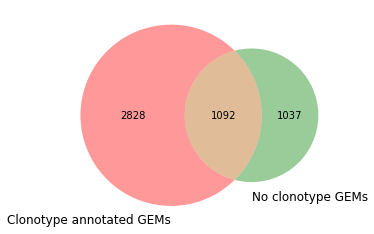

In [222]:
from matplotlib_venn import venn2

set1 = set(df[~df.clonotype.isnull()].gem.unique())
set2 = set(df[df.clonotype.isnull()].gem.unique())

venn2([set1, set2], ('Clonotype annotated GEMs', 'No clonotype GEMs'))

plt.show()

In [228]:
df[df.gem.isin(non_ann_gems)]

,gem,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,cdr3_nt,fwr4,fwr4_nt,read_count,umi_count,clonotype,raw_consensus_id,exact_subclonotype_id,genes,ct
35,AAACGGGAGGACATTA-1,False,AAACGGGAGGACATTA-1_contig_1,True,508,TRB,TRBV7-3,NaN,TRBJ2-1,TRBC2,...,TGTGCCAGCAGCTTAATAGTGAGCGGGGGGGCCAATGAGCAGTTCTTC,NaN,NaN,6720,19,NaN,NaN,NaN,CASSLIVSGGANEQFF;TRBV7-3;TRBJ2-1,NaN
36,AAACGGGAGGACATTA-1,False,AAACGGGAGGACATTA-1_contig_2,True,495,TRB,TRBV27,NaN,TRBJ2-7,TRBC2,...,TGTGCCAGCAGTTTAGTAGCGGGTGCCCCCAGCGAGCAGTACTTC,NaN,NaN,2442,7,NaN,NaN,NaN,CASSLVAGAPSEQYF;TRBV27;TRBJ2-7,NaN
37,AAACGGGAGGACATTA-1,False,AAACGGGAGGACATTA-1_contig_3,True,541,TRA,TRAV16,NaN,TRAJ47,TRAC,...,TGTGCTCTAAGGGACATGGAATATGGAAACAAGCTGGTCTTT,NaN,NaN,724,2,NaN,NaN,NaN,CALRDMEYGNKLVF;TRAV16;TRAJ47,NaN
38,AAACGGGAGGACATTA-1,False,AAACGGGAGGACATTA-1_contig_4,True,609,TRA,TRAV3,NaN,TRAJ47,TRAC,...,TGTGCTGTGAATTATGGAAACAAACTGGTCTTT,NaN,NaN,690,4,NaN,NaN,NaN,CAVNYGNKLVF;TRAV3;TRAJ47,NaN
61,AAAGATGGTGACGGTA-1,False,AAAGATGGTGACGGTA-1_contig_1,False,476,TRB,TRBV9,NaN,TRBJ2-7,TRBC2,...,TGTGCCAGCAGCGTAGGATCAGGCAGCTCCTACGAGCAGTACTTC,NaN,NaN,68,1,NaN,NaN,NaN,CASSVGSGSSYEQYF;TRBV9;TRBJ2-7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10178,TTTGGTTTCCTCAACC-1,False,TTTGGTTTCCTCAACC-1_contig_1,False,508,TRB,TRBV7-3,NaN,TRBJ2-1,TRBC2,...,TGTGCCAGCAGCTTAATAGTGAGCGGGGGGGCCAATGAGCAGTTCTTC,NaN,NaN,2336,13,NaN,NaN,NaN,CASSLIVSGGANEQFF;TRBV7-3;TRBJ2-1,NaN
10179,TTTGGTTTCCTCAACC-1,False,TTTGGTTTCCTCAACC-1_contig_2,False,511,TRA,TRAV2,NaN,TRAJ43,TRAC,...,TGTGCTGTGGAGGATCGGCTTGACAATGACATGCGCTTT,NaN,NaN,952,8,NaN,NaN,NaN,CAVEDRLDNDMRF;TRAV2;TRAJ43,NaN
10180,TTTGGTTTCCTCAACC-1,False,TTTGGTTTCCTCAACC-1_contig_3,False,503,TRB,TRBV20-1,NaN,TRBJ1-2,TRBC1,...,TGCAGTGCTAGAGGACTGGGACAGGCGAAGGAGTATGGCTACACCTTC,NaN,NaN,1562,5,NaN,NaN,NaN,CSARGLGQAKEYGYTF;TRBV20-1;TRBJ1-2,NaN
10181,TTTGGTTTCCTCAACC-1,False,TTTGGTTTCCTCAACC-1_contig_4,False,520,TRB,TRBV11-2,TRBD1,TRBJ1-4,TRBC1,...,TGTGCCAGCAGCTCCCCGGGGTCGGGGGCTTCCGAAAAACTGTTTTTT,NaN,NaN,1466,5,NaN,NaN,NaN,CASSSPGSGASEKLFF;TRBV11-2;TRBJ1-4,NaN


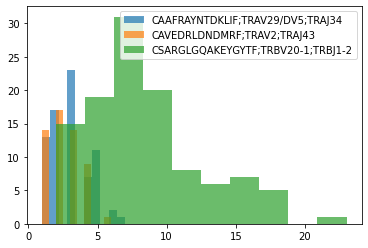

In [241]:
for i, chain in df[df.clonotype == 'clonotype5'].groupby('genes').umi_count.apply(lambda x: list(x)).items():
    plt.hist(chain, label=i, alpha=0.7)
plt.legend()
plt.show()

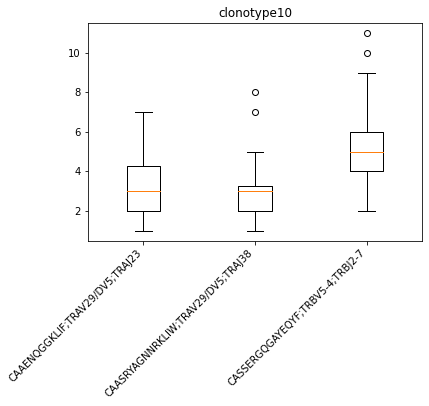

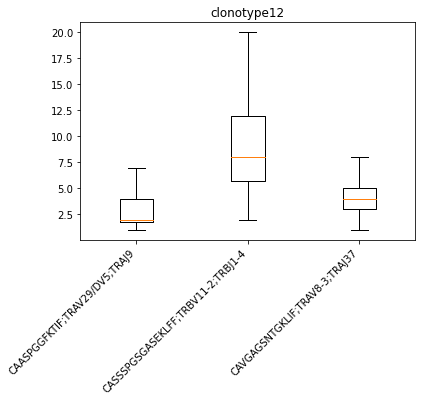

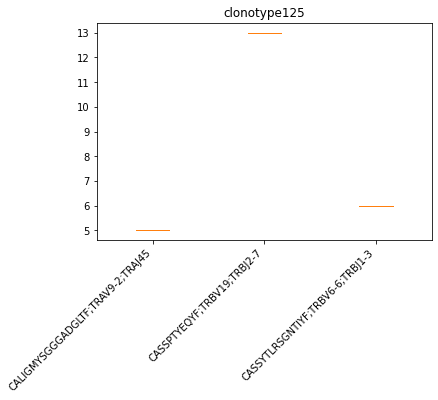

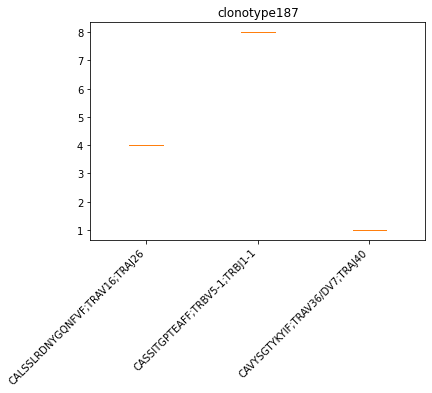

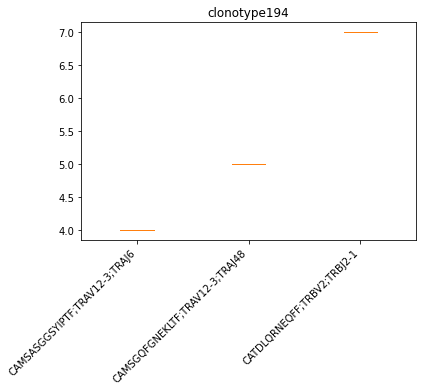

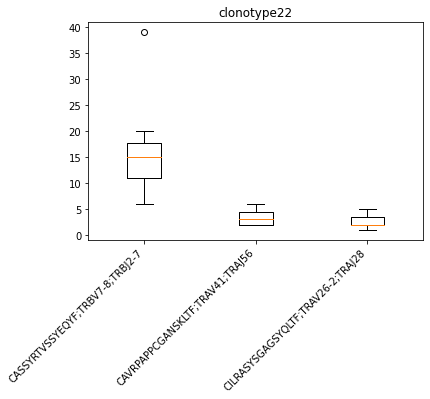

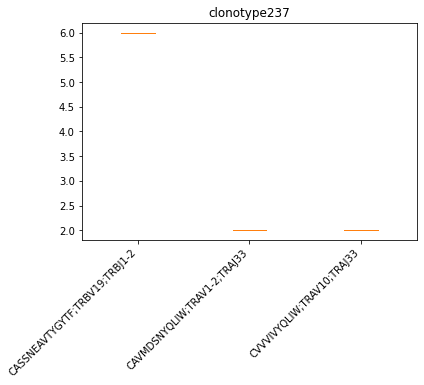

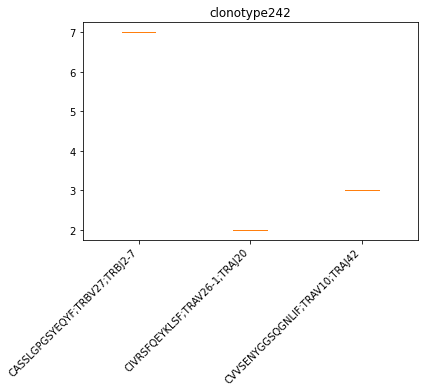

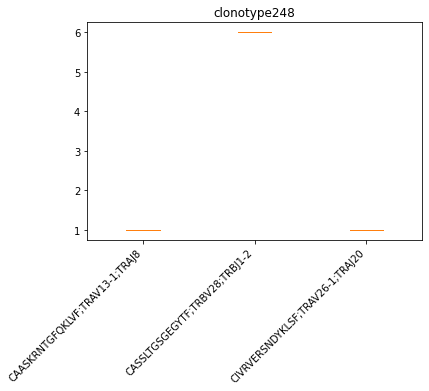

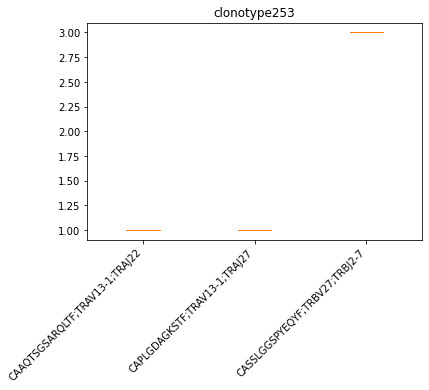

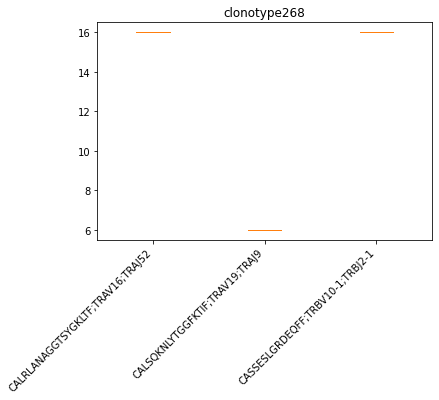

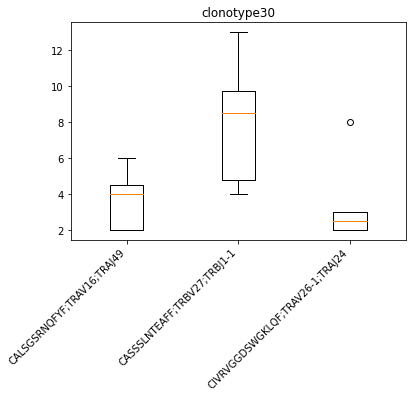

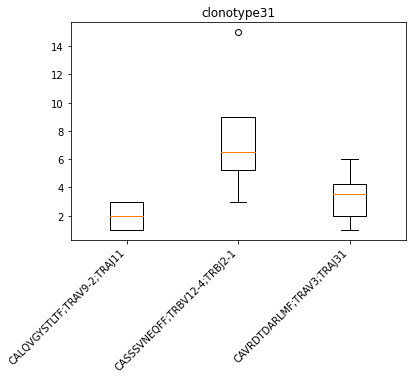

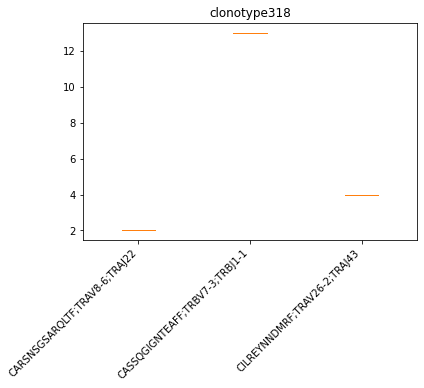

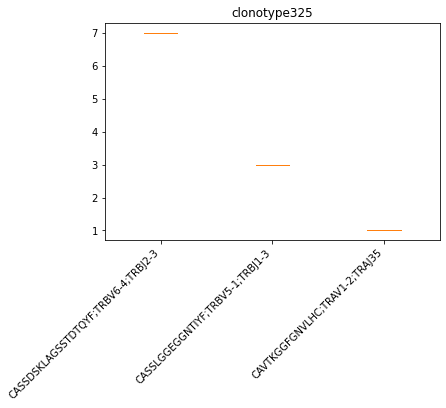

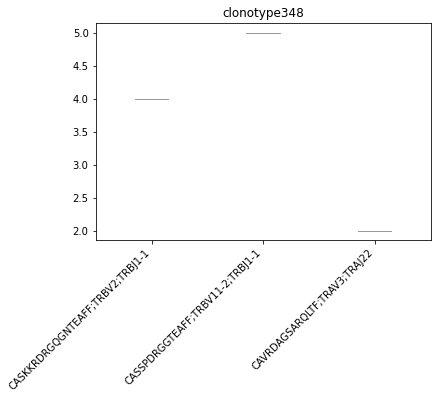

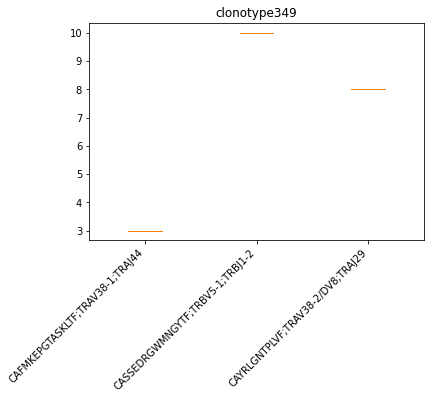

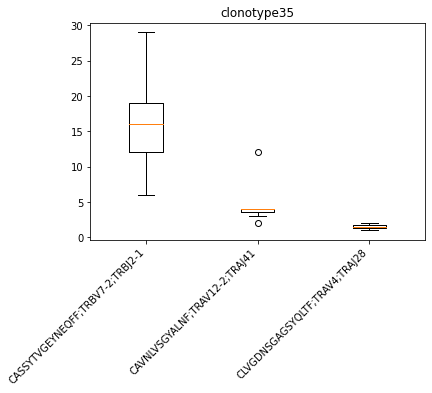

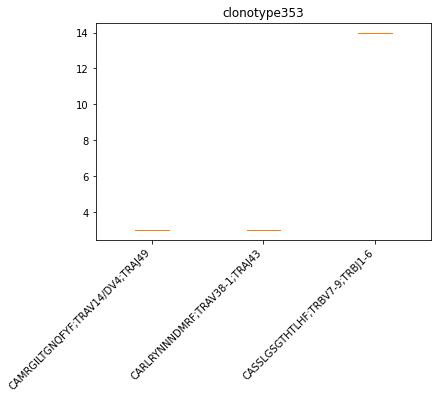

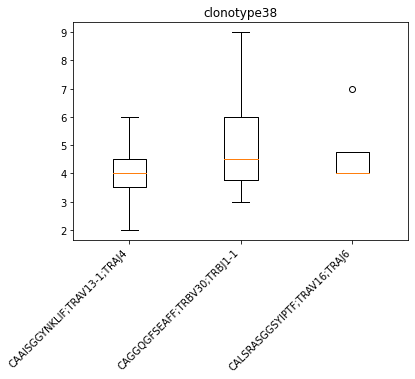

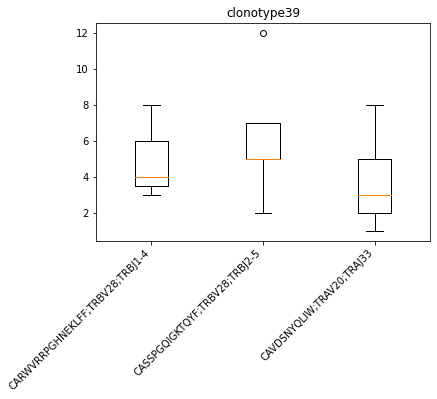

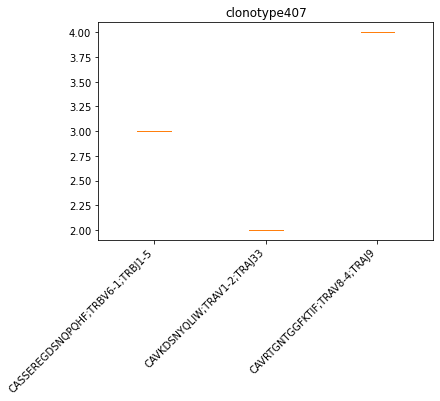

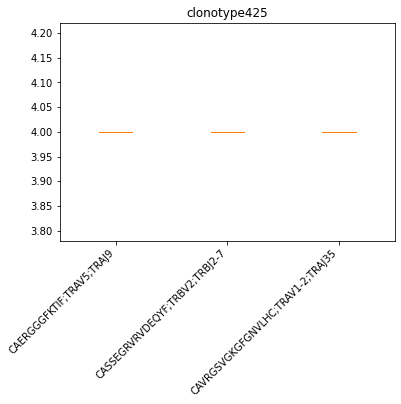

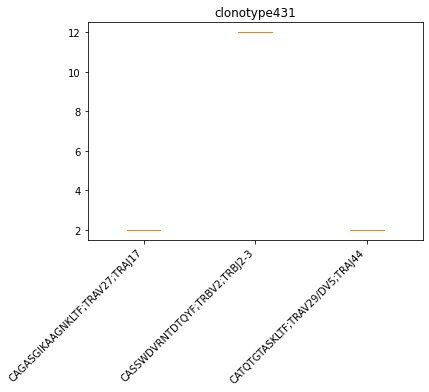

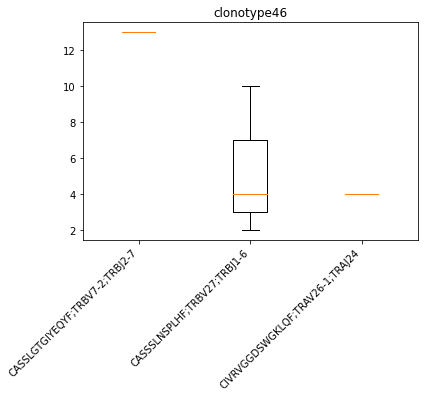

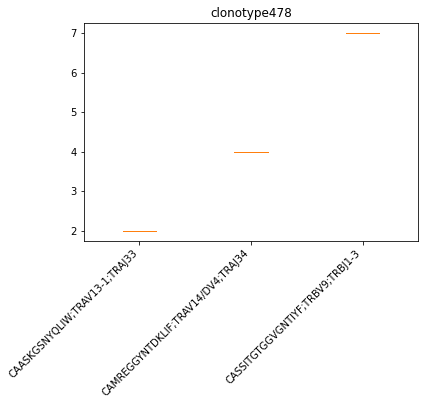

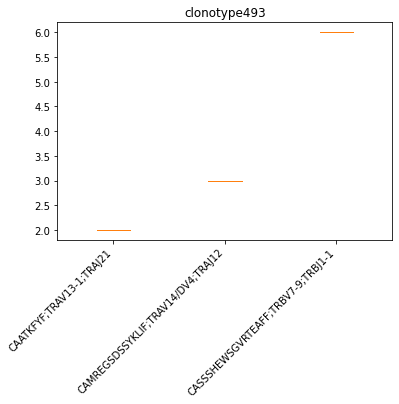

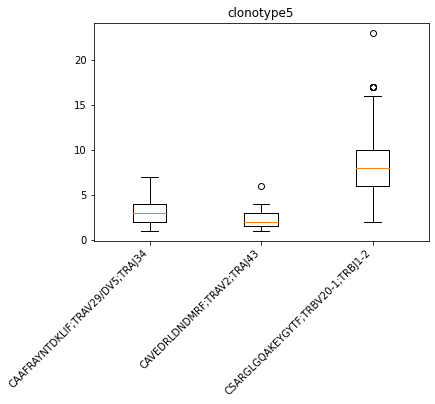

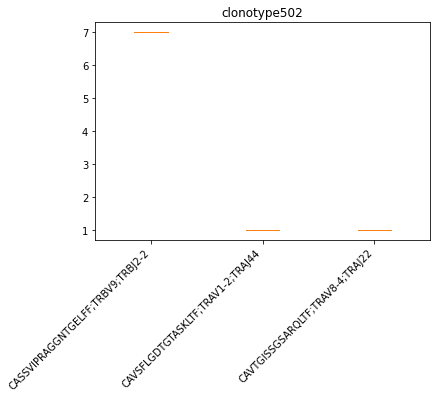

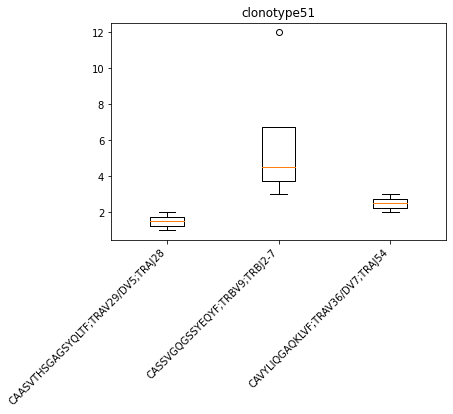

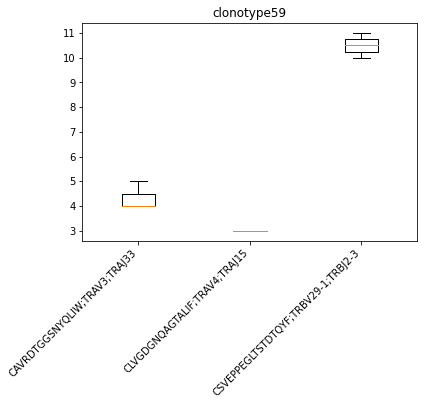

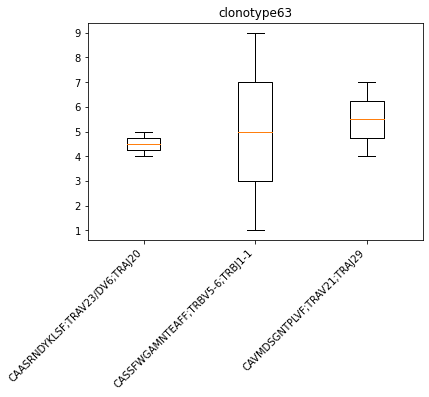

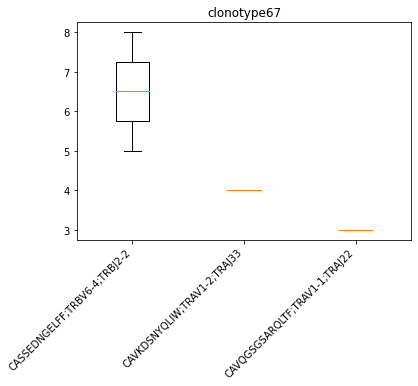

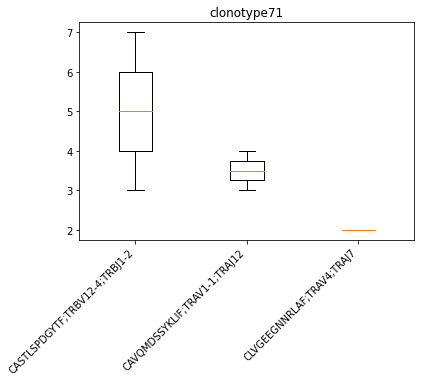

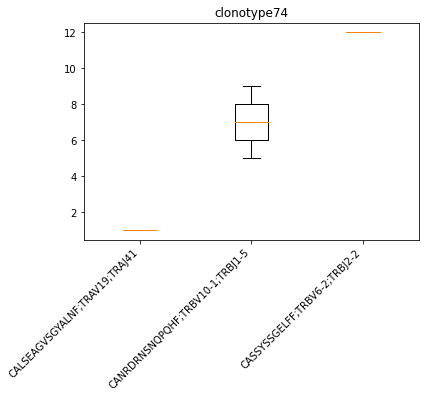

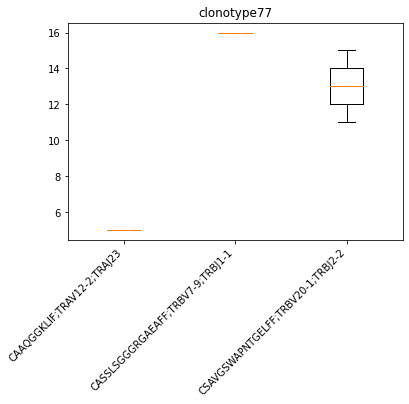

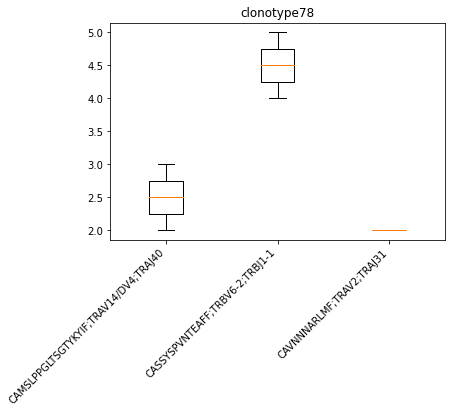

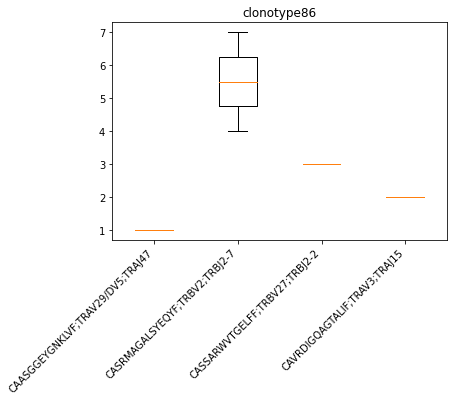

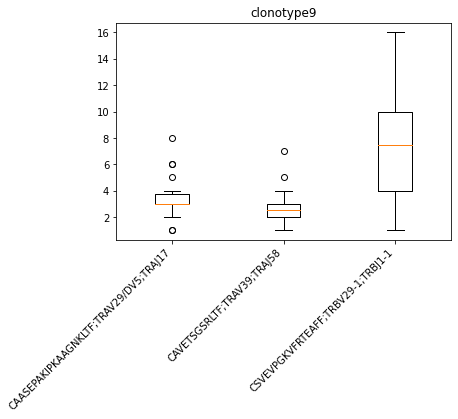

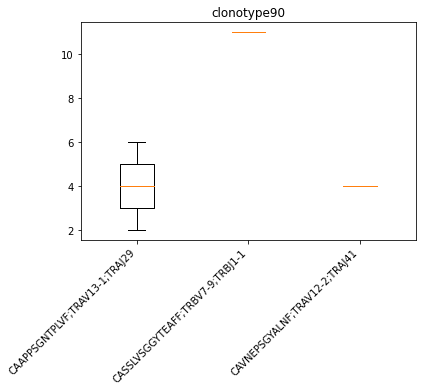

In [251]:
for clone in clone_multiplets:
    data = df[df.clonotype == clone].groupby('genes').umi_count.apply(lambda x: list(x))
    labels = data.index
    plt.boxplot(data)
    plt.xticks(np.arange(1,len(data)+1), labels, rotation=45, ha='right')
    plt.title(clone)
    plt.show()

In [233]:
df.loc[df.clonotype == 'clonotype5',['contig_id','v_gene','j_gene','cdr3','read_count','umi_count']].head(60)

,contig_id,v_gene,j_gene,cdr3,read_count,umi_count
10,AAACCTGAGTAATCCC-1_contig_1,TRBV20-1,TRBJ1-2,CSARGLGQAKEYGYTF,5526,14
11,AAACCTGAGTAATCCC-1_contig_2,TRAV29/DV5,TRAJ34,CAAFRAYNTDKLIF,394,1
12,AAACCTGAGTAATCCC-1_contig_3,TRAV2,TRAJ43,CAVEDRLDNDMRF,294,1
123,AAATGCCTCTTGTATC-1_contig_1,TRAV2,TRAJ43,CAVEDRLDNDMRF,706,3
124,AAATGCCTCTTGTATC-1_contig_2,TRBV20-1,TRBJ1-2,CSARGLGQAKEYGYTF,1758,7
486,AATCGGTTCATCTGCC-1_contig_1,TRBV20-1,TRBJ1-2,CSARGLGQAKEYGYTF,2426,7
487,AATCGGTTCATCTGCC-1_contig_2,TRAV29/DV5,TRAJ34,CAAFRAYNTDKLIF,812,3
489,ACACCAAAGAACAACT-1_contig_1,TRBV20-1,TRBJ1-2,CSARGLGQAKEYGYTF,1376,5
560,ACACCGGCAGACGCAA-1_contig_1,TRBV20-1,TRBJ1-2,CSARGLGQAKEYGYTF,1332,7
708,ACCAGTACAATGGAAT-1_contig_1,TRBV20-1,TRBJ1-2,CSARGLGQAKEYGYTF,4654,13


In [116]:
df[df.genes.isin(grp.genes) & df.clonotype.isnull()]

,gem,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,cdr3,cdr3_nt,fwr4,fwr4_nt,read_count,umi_count,clonotype,raw_consensus_id,exact_subclonotype_id,genes
2,AAACCTGAGAGGTAGA-1,True,AAACCTGAGAGGTAGA-1_contig_3,True,467,TRA,TRAV13-1,NaN,TRAJ42,TRAC,...,NaN,NaN,NaN,NaN,140,2,NaN,NaN,NaN,;TRAV13-1;TRAJ42
122,AAATGCCTCTCTAAGG-1,True,AAATGCCTCTCTAAGG-1_contig_4,True,467,TRA,TRAV13-1,NaN,TRAJ42,TRAC,...,NaN,NaN,NaN,NaN,692,2,NaN,NaN,NaN,;TRAV13-1;TRAJ42
270,AACTGGTCAAGTAGTA-1,False,AACTGGTCAAGTAGTA-1_contig_1,False,467,TRA,TRAV13-1,NaN,TRAJ42,TRAC,...,NaN,NaN,NaN,NaN,458,1,NaN,NaN,NaN,;TRAV13-1;TRAJ42
300,AAGACCTAGAGTCGGT-1,True,AAGACCTAGAGTCGGT-1_contig_3,True,467,TRA,TRAV13-1,NaN,TRAJ42,TRAC,...,NaN,NaN,NaN,NaN,256,1,NaN,NaN,NaN,;TRAV13-1;TRAJ42
326,AAGACCTTCTGCCAGG-1,True,AAGACCTTCTGCCAGG-1_contig_3,True,467,TRA,TRAV13-1,NaN,TRAJ42,TRAC,...,NaN,NaN,NaN,NaN,388,1,NaN,NaN,NaN,;TRAV13-1;TRAJ42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9954,TTGACTTCACCATCCT-1,True,TTGACTTCACCATCCT-1_contig_3,True,549,TRA,TRAV13-1,NaN,TRAJ42,TRAC,...,NaN,NaN,NaN,NaN,466,2,NaN,NaN,NaN,;TRAV13-1;TRAJ42
10030,TTGGCAAAGCCGGTAA-1,True,TTGGCAAAGCCGGTAA-1_contig_3,True,467,TRA,TRAV13-1,NaN,TRAJ42,TRAC,...,NaN,NaN,NaN,NaN,294,1,NaN,NaN,NaN,;TRAV13-1;TRAJ42
10073,TTGTAGGTCAGGCGAA-1,True,TTGTAGGTCAGGCGAA-1_contig_4,True,467,TRA,TRAV13-1,NaN,TRAJ42,TRAC,...,NaN,NaN,NaN,NaN,342,2,NaN,NaN,NaN,;TRAV13-1;TRAJ42
10120,TTTCCTCAGTCCGGTC-1,True,TTTCCTCAGTCCGGTC-1_contig_3,True,525,TRA,TRAV13-1,NaN,TRAJ42,TRAC,...,NaN,NaN,NaN,NaN,116,1,NaN,NaN,NaN,;TRAV13-1;TRAJ42


In [121]:
df[~df.clonotype.isnull()].groupby('genes').raw_consensus_id.unique().head(60)

genes
CAAADSSNDYKLSF;TRAV29/DV5;TRAJ20                                 [clonotype13_consensus_2]
CAAAETSYDKVIF;TRAV13-1;TRAJ50                                    [clonotype41_consensus_2]
CAADVTDSWGKFQF;TRAV29/DV5;TRAJ24                                [clonotype369_consensus_2]
CAAEARDNYGQNFVF;TRAV13-1;TRAJ26                                 [clonotype345_consensus_2]
CAAENQGGKLIF;TRAV29/DV5;TRAJ23           [clonotype10_consensus_2, clonotype512_consens...
CAAFFGNEKLTF;TRAV41;TRAJ48                                      [clonotype421_consensus_2]
CAAFRAYNTDKLIF;TRAV29/DV5;TRAJ34                                  [clonotype5_consensus_2]
CAAFTGTASKLTF;TRAV12-2;TRAJ44                                   [clonotype503_consensus_2]
CAAFTSGTYKYIF;TRAV13-1;TRAJ40                                   [clonotype499_consensus_2]
CAAGYNFNKFYF;TRAV29/DV5;TRAJ21                                  [clonotype485_consensus_2]
CAAHHDYNQGGKLIF;TRAV12-2;TRAJ23                                 [clonotype124_consen

In [120]:
df[df.clonotype.isin(['clonotype10', 'clonotype512', 'clonotype513'])]

,gem,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,cdr3,cdr3_nt,fwr4,fwr4_nt,read_count,umi_count,clonotype,raw_consensus_id,exact_subclonotype_id,genes
5,AAACCTGAGCCAGGAT-1,True,AAACCTGAGCCAGGAT-1_contig_1,True,653,TRB,TRBV5-4,TRBD1,TRBJ2-7,TRBC2,...,CASSERGQGAYEQYF,TGTGCCAGCAGCGAAAGGGGACAGGGGGCTTACGAGCAGTACTTC,GPGTRLTVT,GGGCCGGGCACCAGGCTCACGGTCACAG,768,3,clonotype10,clonotype10_consensus_1,1.0,CASSERGQGAYEQYF;TRBV5-4;TRBJ2-7
6,AAACCTGAGCCAGGAT-1,True,AAACCTGAGCCAGGAT-1_contig_2,True,508,TRA,TRAV29/DV5,NaN,TRAJ23,TRAC,...,CAAENQGGKLIF,TGTGCAGCGGAGAACCAGGGAGGAAAGCTTATCTTC,GQGTELSVKP,GGACAGGGAACGGAGTTATCTGTGAAACCCA,766,5,clonotype10,clonotype10_consensus_2,1.0,CAAENQGGKLIF;TRAV29/DV5;TRAJ23
7,AAACCTGAGCCAGGAT-1,True,AAACCTGAGCCAGGAT-1_contig_3,True,511,TRA,TRAV29/DV5,NaN,TRAJ38,TRAC,...,CAASRYAGNNRKLIW,TGTGCAGCAAGCCGGTATGCTGGCAACAACCGTAAGCTGATTTGG,GLGTSLAVNP,GGATTGGGAACAAGCCTGGCAGTAAATCCGA,402,2,clonotype10,clonotype10_consensus_3,1.0,CAASRYAGNNRKLIW;TRAV29/DV5;TRAJ38
393,AAGGTTCAGGCATTGG-1,True,AAGGTTCAGGCATTGG-1_contig_1,True,538,TRA,TRAV29/DV5,NaN,TRAJ38,TRAC,...,CAASRYAGNNRKLIW,TGTGCAGCAAGCCGGTATGCTGGCAACAACCGTAAGCTGATTTGG,GLGTSLAVNP,GGATTGGGAACAAGCCTGGCAGTAAATCCGA,394,1,clonotype10,clonotype10_consensus_3,1.0,CAASRYAGNNRKLIW;TRAV29/DV5;TRAJ38
394,AAGGTTCAGGCATTGG-1,True,AAGGTTCAGGCATTGG-1_contig_2,True,565,TRA,TRAV29/DV5,NaN,TRAJ23,TRAC,...,CAAENQGGKLIF,TGTGCAGCGGAGAACCAGGGAGGAAAGCTTATCTTC,GQGTELSVKP,GGACAGGGAACGGAGTTATCTGTGAAACCCA,380,3,clonotype10,clonotype10_consensus_2,1.0,CAAENQGGKLIF;TRAV29/DV5;TRAJ23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9610,TGTCCCAAGATCTGAA-1,True,TGTCCCAAGATCTGAA-1_contig_1,True,565,TRA,TRAV29/DV5,NaN,TRAJ23,TRAC,...,CAAENQGGKLIF,TGTGCAGCGGAGAACCAGGGAGGAAAGCTTATCTTC,GQGTELSVKP,GGACAGGGAACGGAGTTATCTGTGAAACCCA,242,1,clonotype10,clonotype10_consensus_2,1.0,CAAENQGGKLIF;TRAV29/DV5;TRAJ23
9611,TGTCCCAAGATCTGAA-1,True,TGTCCCAAGATCTGAA-1_contig_2,True,517,TRA,TRAV29/DV5,NaN,TRAJ38,TRAC,...,CAASRYAGNNRKLIW,TGTGCAGCAAGCCGGTATGCTGGCAACAACCGTAAGCTGATTTGG,GLGTSLAVNP,GGATTGGGAACAAGCCTGGCAGTAAATCCGA,166,2,clonotype10,clonotype10_consensus_3,1.0,CAASRYAGNNRKLIW;TRAV29/DV5;TRAJ38
9612,TGTCCCAAGATCTGAA-1,True,TGTCCCAAGATCTGAA-1_contig_3,True,653,TRB,TRBV5-4,TRBD1,TRBJ2-7,TRBC2,...,CASSERGQGAYEQYF,TGTGCCAGCAGCGAAAGGGGACAGGGGGCTTACGAGCAGTACTTC,GPGTRLTVT,GGGCCGGGCACCAGGCTCACGGTCACAG,524,4,clonotype10,clonotype10_consensus_1,1.0,CASSERGQGAYEQYF;TRBV5-4;TRBJ2-7
9989,TTGCGTCAGTGTTAGA-1,True,TTGCGTCAGTGTTAGA-1_contig_1,True,650,TRB,TRBV5-4,TRBD1,TRBJ2-7,TRBC2,...,CASSERGQGAYEQYF,TGTGCCAGCAGCGAAAGGGGACAGGGGGCTTACGAGCAGTACTTC,GPGTRLTVT,GGGCCGGGCACCAGGCTCACGGTCACAG,418,5,clonotype10,clonotype10_consensus_1,2.0,CASSERGQGAYEQYF;TRBV5-4;TRBJ2-7


In [96]:
mult_v_gene = df.groupby(['clonotype']).cdr3.unique().apply(lambda x: len(x)) > 3

In [97]:
mult_v_gene_ct = df.groupby('clonotype').cdr3.unique()[mult_v_gene.values].index

In [98]:
df[df.clonotype.isin(mult_v_gene_ct)]

,gem,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,fwr3_nt,cdr3,cdr3_nt,fwr4,fwr4_nt,read_count,umi_count,clonotype,raw_consensus_id,exact_subclonotype_id
4158,CGGACTGAGAGATGAG-1,True,CGGACTGAGAGATGAG-1_contig_1,True,508,TRB,TRBV2,NaN,TRBJ2-7,TRBC2,...,TCAGAGAAGTCTGAAATATTCGATGATCAATTCTCAGTTGAAAGGC...,CASRMAGALSYEQYF,TGTGCCAGCAGGATGGCAGGGGCCCTATCCTACGAGCAGTACTTC,GPGTRLTVT,GGGCCGGGCACCAGGCTCACGGTCACAG,1210,4,clonotype86,clonotype86_consensus_1,1.0
4159,CGGACTGAGAGATGAG-1,True,CGGACTGAGAGATGAG-1_contig_2,True,492,TRB,TRBV27,NaN,TRBJ2-2,TRBC2,...,ACTGATAAGGGAGATGTTCCTGAAGGGTACAAAGTCTCTCGAAAAG...,CASSARWVTGELFF,TGTGCCAGCAGTGCCCGTTGGGTCACCGGGGAGCTGTTTTTT,GEGSRLTVL,GGAGAAGGCTCTAGGCTGACCGTACTGG,1172,3,clonotype86,clonotype86_consensus_2,1.0
4160,CGGACTGAGAGATGAG-1,True,CGGACTGAGAGATGAG-1_contig_3,True,621,TRA,TRAV3,NaN,TRAJ15,TRAC,...,AAAGGCAGCTATGGCTTTGAAGCTGAATTTAACAAGAGCCAAACCT...,CAVRDIGQAGTALIF,TGTGCTGTGAGAGACATAGGCCAGGCAGGAACTGCTCTGATCTTT,GKGTTLSVSS,GGGAAGGGAACCACCTTATCAGTGAGTTCCA,690,2,clonotype86,clonotype86_consensus_4,1.0
4161,CGGACTGAGAGATGAG-1,True,CGGACTGAGAGATGAG-1_contig_4,True,571,TRA,TRAV29/DV5,NaN,TRAJ47,TRAC,...,AATGAAGATGGAAGATTCACTGTCTTCTTAAACAAAAGTGCCAAGC...,CAASGGEYGNKLVF,TGTGCAGCAAGCGGAGGGGAATATGGAAACAAACTGGTCTTT,GAGTILRVKS,GGCGCAGGAACCATTCTGAGAGTCAAGTCCT,274,1,clonotype86,clonotype86_consensus_3,1.0
7855,GTTCGGGCATGGTCTA-1,True,GTTCGGGCATGGTCTA-1_contig_1,True,529,TRB,TRBV2,NaN,TRBJ2-7,TRBC2,...,TCAGAGAAGTCTGAAATATTCGATGATCAATTCTCAGTTGAAAGGC...,CASRMAGALSYEQYF,TGTGCCAGCAGGATGGCAGGGGCCCTATCCTACGAGCAGTACTTC,GPGTRLTVT,GGGCCGGGCACCAGGCTCACGGTCACAG,2184,7,clonotype86,clonotype86_consensus_1,2.0


In [61]:
tcr_df.groupby(['clonotype']).v_gene_TRA.unique()#.apply(lambda x: len(x)) > 1)

clonotype
clonotype1          [TRAV21, nan]
clonotype10     [TRAV29/DV5, nan]
clonotype100             [TRAV21]
clonotype101              [TRAV5]
clonotype102         [TRAV29/DV5]
                      ...        
clonotype95          [TRAV14/DV4]
clonotype96          [TRAV29/DV5]
clonotype97              [TRAV10]
clonotype98         [TRAV17, nan]
clonotype99     [TRAV29/DV5, nan]
Name: v_gene_TRA, Length: 522, dtype: object

In [37]:
def assign_clonotype():
    clonotype_variables = ['v_gene_TRA','j_gene_TRA',
                           'v_gene_TRB','j_gene_TRB',
                           'cdr3_comb']
    tcr_df.loc[:, clonotype_variables] = tcr_df.loc[:, clonotype_variables].fillna('unknown')
    new_clonotype = tcr_df.groupby(clonotype_variables).gem.unique().to_frame()
    new_clonotype['n_gems'] = new_clonotype.gem.apply(len)
    new_clonotype.sort_values(by='n_gems', ascending=False, inplace=True)
    dct = new_clonotype.to_dict()['gem']
    for i, k in enumerate(dct.keys(), start=1): 
        dct[k] = i
    return tcr_df.set_index(clonotype_variables).index.map(dct)

In [38]:
tcr_df['ct'] = assign_clonotype()

In [39]:
assert tcr_df.ct.isna().any() == False

## Write data

In [150]:
new_column_order = ['gem', 'clonotype', 'num_clonotype', 'ct',
                    'length_TRA', 'cdr3_TRA', 'umi_count_TRA', 'umi_count_lst_TRA', 'cdr3_lst_TRA', 'chain_count_TRA','single_TRA',
                    'length_TRB', 'cdr3_TRB', 'umi_count_TRB', 'umi_count_lst_TRB', 'cdr3_lst_TRB', 'chain_count_TRB','single_TRB',
                    'single_chain_only', 'umi_count_tcr', 'cdr3_comb', 'tcr_category', 'no_filtration', 'exclude_single-chain_TCRs', 'exclude_ambiguous_and_single-chain_TCRs']

In [151]:
tcr_df[new_column_order].to_csv(file_out, index=False)

# Testing

In [42]:
tcr_df[tcr_df['exclude_single-chain_TCRs']]

,gem,is_cell_TRA,contig_id_TRA,high_confidence_TRA,length_TRA,chain_TRA,v_gene_TRA,d_gene_TRA,j_gene_TRA,c_gene_TRA,...,single_TRB,num_clonotype,single_chain_only,umi_count_tcr,cdr3_comb,tcr_category,no_filtration,exclude_single-chain_TCRs,exclude_ambiguous_and_single-chain_TCRs,ct
0,AAACCTGAGAATTGTG-1,True,AAACCTGAGAATTGTG-1_contig_1,True,548.0,TRA,TRAV29DV5,None,TRAJ45,TRAC,...,True,2,False,27.0,CAAKSDSGGGADGLTFCASSAWTSNRDEQFF,unique chains,True,True,True,3
1,AAACCTGAGACTAGGC-1,True,AAACCTGAGACTAGGC-1_contig_3,True,525.0,TRA,TRAV27,None,TRAJ28,TRAC,...,True,3,False,12.0,CAGARSYQLTFCASSPLSLNTEAFF,unique chains,True,True,True,6
2,AAACCTGAGAGTCTGG-1,True,AAACCTGAGAGTCTGG-1_contig_2,True,692.0,TRA,TRAV8-6,None,TRAJ41,TRAC,...,True,29,False,95.0,CAVSSNSNSGYALNFCASSFDRDEQYF,unique chains,True,True,True,52
3,AAACCTGAGGCCGAAT-1,True,AAACCTGAGGCCGAAT-1_contig_4,True,584.0,TRA,TRAV12-2,None,TRAJ23,TRAC,...,False,519,False,43.0,CAAQGGKLIFCASSFQGAETQYF,multiple chains,True,True,False,2371
5,AAACCTGAGTTCGATC-1,True,AAACCTGAGTTCGATC-1_contig_2,True,542.0,TRA,TRAV14DV4,None,TRAJ9,TRAC,...,True,9,False,8.0,CALNTGGFKTIFCASSPPFLAGSGSSYEQYF,unique chains,True,True,True,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7509,TTTGTCAGTGCAGGTA-1,True,TTTGTCAGTGCAGGTA-1_contig_2,True,543.0,TRA,TRAV13-1,None,TRAJ45,TRAC,...,True,73,False,11.0,CAASWRPDSGGGADGLTFCSASKREVWNIQYF,unique chains,True,True,True,155
7510,TTTGTCAGTGGAAAGA-1,True,TTTGTCAGTGGAAAGA-1_contig_1,True,581.0,TRA,TRAV29DV5,None,TRAJ45,TRAC,...,True,2,False,14.0,CAAKSDSGGGADGLTFCASSAWTSNRDEQFF,unique chains,True,True,True,3
7511,TTTGTCATCAACGGCC-1,True,TTTGTCATCAACGGCC-1_contig_2,True,521.0,TRA,TRAV27,None,TRAJ28,TRAC,...,True,3,False,12.0,CAGARSYQLTFCASSPLSLNTEAFF,unique chains,True,True,True,6
7513,TTTGTCATCGACAGCC-1,True,TTTGTCATCGACAGCC-1_contig_4,True,572.0,TRA,TRAV29DV5,None,TRAJ40,TRAC,...,True,24,False,142.0,CAASFSGTYKYIFCASSLVAYNEQFF,unique chains,True,True,True,47


In [46]:
import re
regex = re.findall('unique_tcrs', 'lalalalaldkfjaoiwe/unique_tcrs/asdf')
if regex:
    print(regex)
else:
    print('nothing')

['unique_tcrs']


In [53]:
tcr_df.groupby(['v_gene_TRA','d_gene_TRA','j_gene_TRA','c_gene_TRA',
                'v_gene_TRB','d_gene_TRB','j_gene_TRB','c_gene_TRB',
                'cdr3_comb']).clonotype.unique().to_frame()#.to_csv("/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/" + EXP + "_TCR/augmented/tcr.clonotypes.csv")

clonotype
v_gene_TRA d_gene_TRA j_gene_TRA c_gene_TRA v_gene_TRB d_gene_TRB j_gene_TRB c_gene_TRB cdr3_comb                                        
TRAV1-1    None       TRAJ36     TRAC       TRBV2      TRBD1      TRBJ2-5    TRBC2      CAVTPGANNLFFCASSEATGTGETQYF         [clonotype19]
                      TRAJ4      TRAC       unknown    unknown    unknown    unknown    CAVAGGYNKLIF                               [None]
TRAV1-2    None       TRAJ12     TRAC       TRBV6-3    TRBD1      TRBJ2-3    TRBC2      CAVVDSSYKLIFCASSSPPGEGSDTQYF        [clonotype41]
                                            TRBV6-4    TRBD2      TRBJ2-1    TRBC2      CAVMDSSYKLIFCASSDSSGGASEQFF        [clonotype103]
                      TRAJ15     TRAC       unknown    unknown    unknown    unknown    CAVRDTQAGTALIF                             [None]
...                                                                                                                                   ...
unknown    unknown    unknown    unknown    TRBV7-9    TRBD2      TRBJ2-1    TRBC2      CASGGGEEYNEQFF                             [None]
                                                                                        CASSQIGEGHGDEQFF              [None, clonotype11]
                                            TRBV9      None       TRBJ2-3    TRBC2      CASSPSDILADTQYF                     [clonotype97]
                                                       TRBD1      TRBJ1-6    TRBC1      CASSEGQGNSPLHF                     [clonotype106]
                                                       TRBD2      TRBJ2-1    TRBC2      CASSEATSGISYNEQFF                          [None]

[241 rows x 1 columns]

In [56]:
tcr_df.ct.unique().shape

(241,)

In [44]:
tcr_df.drop(tcr_df[~tcr_df.duplicated(subset='clonotype', keep=False)].index).clonotype

2       None
3       None
4       None
5       None
6       None
        ... 
5418    None
5419    None
5420    None
5421    None
5422    None
Name: clonotype, Length: 5332, dtype: object

In [79]:
tcr_df[(tcr_df.num_clonotype!=1) & (tcr_df.ct==1)].iloc[:,25:]# & (tcr_df.ct==2)

,length_TRB,chain_TRB,v_gene_TRB,d_gene_TRB,j_gene_TRB,c_gene_TRB,full_length_TRB,productive_TRB,cdr3_TRB,cdr3_nt_TRB,...,chain_count_TRB,umi_count_lst_TRB,cdr3_lst_TRB,single_TRB,num_clonotype,single_chain_only,single_tcell,umi_count_tcr,cdr3_comb,ct
7515,464.0,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,True,CASSAWTSNRDEQFF,TGTGCCAGCAGCGCCTGGACTAGTAATCGGGATGAGCAGTTCTTC,...,1.0,[1],[CASSAWTSNRDEQFF],True,0,True,False,1.0,CASSAWTSNRDEQFF,1
7526,477.0,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,True,CASSAWTSNRDEQFF,TGTGCCAGCAGCGCCTGGACTAGTAATCGGGATGAGCAGTTCTTC,...,2.0,"[1, 1]","[CASSFSGSTDTQYF, CASSAWTSNRDEQFF]",False,0,True,False,1.0,CASSAWTSNRDEQFF,1
7529,536.0,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,True,CASSAWTSNRDEQFF,TGTGCCAGCAGCGCCTGGACTAGTAATCGGGATGAGCAGTTCTTC,...,1.0,[6],[CASSAWTSNRDEQFF],True,0,True,False,6.0,CASSAWTSNRDEQFF,1
7535,480.0,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,True,CASSAWTSNRDEQFF,TGTGCCAGCAGCGCCTGGACTAGTAATCGGGATGAGCAGTTCTTC,...,1.0,[2],[CASSAWTSNRDEQFF],True,0,True,False,2.0,CASSAWTSNRDEQFF,1
7541,477.0,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,True,CASSAWTSNRDEQFF,TGTGCCAGCAGCGCCTGGACTAGTAATCGGGATGAGCAGTTCTTC,...,1.0,[1],[CASSAWTSNRDEQFF],True,0,True,False,1.0,CASSAWTSNRDEQFF,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13376,491.0,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,True,CASSAWTSNRDEQFF,TGTGCCAGCAGCGCCTGGACTAGTAATCGGGATGAGCAGTTCTTC,...,1.0,[4],[CASSAWTSNRDEQFF],True,0,True,False,4.0,CASSAWTSNRDEQFF,1
13378,493.0,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,True,CASSAWTSNRDEQFF,TGTGCCAGCAGCGCCTGGACTAGTAATCGGGATGAGCAGTTCTTC,...,1.0,[1],[CASSAWTSNRDEQFF],True,0,True,False,1.0,CASSAWTSNRDEQFF,1
13385,499.0,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,True,CASSAWTSNRDEQFF,TGTGCCAGCAGCGCCTGGACTAGTAATCGGGATGAGCAGTTCTTC,...,2.0,"[1, 1]","[CASEFSETQYF, CASSAWTSNRDEQFF]",False,0,True,False,1.0,CASSAWTSNRDEQFF,1
13386,480.0,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,True,CASSAWTSNRDEQFF,TGTGCCAGCAGCGCCTGGACTAGTAATCGGGATGAGCAGTTCTTC,...,1.0,[1],[CASSAWTSNRDEQFF],True,0,True,False,1.0,CASSAWTSNRDEQFF,1


In [41]:
tcr_df[(tcr_df.num_clonotype==1) & (tcr_df.ct!='c2')].iloc[:,25:]

,length_TRB,chain_TRB,v_gene_TRB,d_gene_TRB,j_gene_TRB,c_gene_TRB,full_length_TRB,productive_TRB,cdr3_TRB,cdr3_nt_TRB,...,chain_count_TRB,umi_count_lst_TRB,cdr3_lst_TRB,single_TRB,num_clonotype,single_chain_only,single_tcell,umi_count_tcr,cdr3_comb,ct
1453,690,TRB,TRBV12-4,TRBD2,TRBJ2-1,TRBC1,True,True,CASRPRVAGGRNEQFF,TGTGCCAGCAGACCCAGAGTAGCGGGAGGGCGCAATGAGCAGTTCTTC,...,3,"[1, 4, 35]","[CASRPRVAGGRNEQFF, CASSAWTSNRDEQFF, CASRPRVAGG...",False,1,False,False,49.0,CAVRSAYSGAGSYQLTFCASRPRVAGGRNEQFF,c122
1888,699,TRB,TRBV12-4,TRBD2,TRBJ2-1,TRBC1,True,True,CASRPRVAGGRNEQFF,TGTGCCAGCAGACCCAGAGTAGCGGGAGGGCGCAATGAGCAGTTCTTC,...,2,"[2, 53]","[CASRPRVAGGRNEQFF, CASRPRVAGGRNEQFF]",False,1,False,False,85.0,CAVRSAYSGAGSYQLTFCASRPRVAGGRNEQFF,c122
1954,700,TRB,TRBV12-4,TRBD2,TRBJ2-1,TRBC1,True,True,CASRPRVAGGRNEQFF,TGTGCCAGCAGACCCAGAGTAGCGGGAGGGCGCAATGAGCAGTTCTTC,...,2,"[1, 39]","[CASRPRVAGGRNEQFF, CASRPRVAGGRNEQFF]",False,1,False,False,71.0,CAVRSAYSGAGSYQLTFCASRPRVAGGRNEQFF,c122
2125,699,TRB,TRBV12-4,TRBD2,TRBJ2-1,TRBC1,True,True,CASRPRVAGGRNEQFF,TGTGCCAGCAGACCCAGAGTAGCGGGAGGGCGCAATGAGCAGTTCTTC,...,1,[66],[CASRPRVAGGRNEQFF],True,1,False,True,148.0,CAVRSAYSGAGSYQLTFCASRPRVAGGRNEQFF,c122
2470,693,TRB,TRBV12-4,TRBD2,TRBJ2-1,TRBC1,True,True,CASRPRVAGGRNEQFF,TGTGCCAGCAGACCCAGAGTAGCGGGAGGGCGCAATGAGCAGTTCTTC,...,2,"[4, 57]","[CASSQDLLANEQFF, CASRPRVAGGRNEQFF]",False,1,False,False,90.0,CAVRSAYSGAGSYQLTFCASRPRVAGGRNEQFF,c122
2921,693,TRB,TRBV12-4,TRBD2,TRBJ2-1,TRBC1,True,True,CASRPRVAGGRNEQFF,TGTGCCAGCAGACCCAGAGTAGCGGGAGGGCGCAATGAGCAGTTCTTC,...,2,"[8, 74]","[CASSSTKAGNQPQHF, CASRPRVAGGRNEQFF]",False,1,False,False,127.0,CAVRSAYSGAGSYQLTFCASRPRVAGGRNEQFF,c122
3515,693,TRB,TRBV12-4,TRBD2,TRBJ2-1,TRBC1,True,True,CASRPRVAGGRNEQFF,TGTGCCAGCAGACCCAGAGTAGCGGGAGGGCGCAATGAGCAGTTCTTC,...,1,[38],[CASRPRVAGGRNEQFF],True,1,False,True,56.0,CAVRSAYSGAGSYQLTFCASRPRVAGGRNEQFF,c122
3612,595,TRB,TRBV12-4,TRBD2,TRBJ2-1,TRBC1,True,True,CASRPRVAGGRNEQFF,TGTGCCAGCAGACCCAGAGTAGCGGGAGGGCGCAATGAGCAGTTCTTC,...,1,[36],[CASRPRVAGGRNEQFF],True,1,False,True,61.0,CAVRSAYSGAGSYQLTFCASRPRVAGGRNEQFF,c122
4024,695,TRB,TRBV12-4,TRBD2,TRBJ2-1,TRBC1,True,True,CASRPRVAGGRNEQFF,TGTGCCAGCAGACCCAGAGTAGCGGGAGGGCGCAATGAGCAGTTCTTC,...,1,[35],[CASRPRVAGGRNEQFF],True,1,False,True,67.0,CAVRSAYSGAGSYQLTFCASRPRVAGGRNEQFF,c122
4469,691,TRB,TRBV12-4,TRBD2,TRBJ2-1,TRBC1,True,True,CASRPRVAGGRNEQFF,TGTGCCAGCAGACCCAGAGTAGCGGGAGGGCGCAATGAGCAGTTCTTC,...,1,[49],[CASRPRVAGGRNEQFF],True,1,False,True,70.0,CAVRSAYSGAGSYQLTFCASRPRVAGGRNEQFF,c122


In [60]:
tcr_df[(tcr_df.ct == 'c1') & (tcr_df.num_clonotype==11)].iloc[:,22:]

,is_cell_TRB,contig_id_TRB,high_confidence_TRB,length_TRB,chain_TRB,v_gene_TRB,d_gene_TRB,j_gene_TRB,c_gene_TRB,full_length_TRB,...,chain_count_TRB,umi_count_lst_TRB,cdr3_lst_TRB,single_TRB,num_clonotype,single_chain_only,single_tcell,umi_count_tcr,cdr3_comb,ct
7732,True,AAGGCAGGTATAGGTA-1_contig_1,True,555,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[10],[CASSAWTSNRDEQFF],True,11,True,False,10.0,CASSAWTSNRDEQFF,c1
7770,True,AATCCAGAGAAACCTA-1_contig_1,True,545,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,2,"[1, 16]","[CASRPRVAGGRNEQFF, CASSAWTSNRDEQFF]",False,11,True,False,16.0,CASSAWTSNRDEQFF,c1
8132,True,ACTGATGTCAACACCA-1_contig_2,True,500,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[4],[CASSAWTSNRDEQFF],True,11,True,False,4.0,CASSAWTSNRDEQFF,c1
8368,True,AGCTTGAGTGTCCTCT-1_contig_1,True,500,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[5],[CASSAWTSNRDEQFF],True,11,True,False,5.0,CASSAWTSNRDEQFF,c1
8560,True,ATAACGCCACGAAAGC-1_contig_1,True,526,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[8],[CASSAWTSNRDEQFF],True,11,True,False,8.0,CASSAWTSNRDEQFF,c1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13117,True,TTAACTCAGTGTACCT-1_contig_1,True,500,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[8],[CASSAWTSNRDEQFF],True,11,True,False,8.0,CASSAWTSNRDEQFF,c1
13267,True,TTCTTAGGTGGCAAAC-1_contig_1,True,501,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[8],[CASSAWTSNRDEQFF],True,11,True,False,8.0,CASSAWTSNRDEQFF,c1
13298,True,TTGCCGTAGCTAGCCC-1_contig_1,True,539,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[9],[CASSAWTSNRDEQFF],True,11,True,False,9.0,CASSAWTSNRDEQFF,c1
13325,True,TTGCGTCTCTCCAACC-1_contig_2,True,500,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,2,"[1, 8]","[CASSLNLGDRSDEQFF, CASSAWTSNRDEQFF]",False,11,True,False,8.0,CASSAWTSNRDEQFF,c1


In [59]:
tcr_df[(tcr_df.ct == 'c1') & (tcr_df.num_clonotype!=11)].iloc[:,22:]

,is_cell_TRB,contig_id_TRB,high_confidence_TRB,length_TRB,chain_TRB,v_gene_TRB,d_gene_TRB,j_gene_TRB,c_gene_TRB,full_length_TRB,...,chain_count_TRB,umi_count_lst_TRB,cdr3_lst_TRB,single_TRB,num_clonotype,single_chain_only,single_tcell,umi_count_tcr,cdr3_comb,ct
7515,False,AAACCTGAGACTGTAA-1_contig_1,True,464,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[1],[CASSAWTSNRDEQFF],True,0,True,False,1.0,CASSAWTSNRDEQFF,c1
7526,False,AAACCTGTCAGAGACG-1_contig_2,False,477,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,2,"[1, 1]","[CASSFSGSTDTQYF, CASSAWTSNRDEQFF]",False,0,True,False,1.0,CASSAWTSNRDEQFF,c1
7529,False,AAACGGGAGCGTGAAC-1_contig_1,True,536,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[6],[CASSAWTSNRDEQFF],True,0,True,False,6.0,CASSAWTSNRDEQFF,c1
7535,False,AAACGGGGTAGGGACT-1_contig_1,True,480,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[2],[CASSAWTSNRDEQFF],True,0,True,False,2.0,CASSAWTSNRDEQFF,c1
7541,False,AAAGATGCACCAACCG-1_contig_1,True,477,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[1],[CASSAWTSNRDEQFF],True,0,True,False,1.0,CASSAWTSNRDEQFF,c1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13376,False,TTTCCTCGTAATTGGA-1_contig_1,True,491,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[4],[CASSAWTSNRDEQFF],True,0,True,False,4.0,CASSAWTSNRDEQFF,c1
13378,False,TTTCCTCGTTCGCTAA-1_contig_1,True,493,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[1],[CASSAWTSNRDEQFF],True,0,True,False,1.0,CASSAWTSNRDEQFF,c1
13385,False,TTTGCGCAGGCAGTCA-1_contig_2,False,499,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,2,"[1, 1]","[CASEFSETQYF, CASSAWTSNRDEQFF]",False,0,True,False,1.0,CASSAWTSNRDEQFF,c1
13386,False,TTTGCGCAGTTACCCA-1_contig_1,True,480,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[1],[CASSAWTSNRDEQFF],True,0,True,False,1.0,CASSAWTSNRDEQFF,c1


In [61]:
tcr_df.groupby('cdr3_comb').clonotype.unique()

cdr3_comb
CAAAETSYDKVIFCASRVGEANYGYTF                         [clonotype2245]
CAAAETSYDKVIFCASSSTGAGNQPQHF                         [clonotype354]
CAAAMDSNYQLIWCASSLIGGGTEAFF                          [clonotype842]
CAAANAGGTSYGKLTF                                             [None]
CAAANAGGTSYGKLTFCASSLGQFYEQYF         [clonotype1015, clonotype307]
                                                ...                
CVYNQGGKLIF                                   [None, clonotype1235]
CVYNQGGKLIFCASSPPGTVSSYEQYF                         [clonotype2219]
CVYNQGGKLIFCASSQARDPTGELFF       [clonotype42, None, clonotype1758]
CWPRSNYQLIWCASSQGLAGGYEQYF                                   [None]
CYPIPRHDTVYCLLGTSGTGNEQFF                                    [None]
Name: clonotype, Length: 3295, dtype: object

In [67]:
tcr_df[tcr_df.cdr3_comb == 'CAAANAGGTSYGKLTFCASSLGQFYEQYF'].iloc[:,12:]

,cdr3_TRA,cdr3_nt_TRA,read_count_TRA,umi_count_TRA,clonotype,raw_consensus_id_TRA,chain_count_TRA,umi_count_lst_TRA,cdr3_lst_TRA,single_TRA,...,chain_count_TRB,umi_count_lst_TRB,cdr3_lst_TRB,single_TRB,num_clonotype,single_chain_only,single_tcell,umi_count_tcr,cdr3_comb,ct
1664,CAAANAGGTSYGKLTF,TGTGCCGCCGCTAATGCTGGTGGTACTAGCTATGGAAAGCTGACATTT,1678,16,clonotype1015,clonotype1015_consensus_4,4,"[1, 5, 11, 16]","[CAAANAGGTSYGKLTF, CAVDNAGNMLTF, CAPRYGGSQGNLI...",False,...,2,"[13, 17]","[CSAPTPAGTLVWETQYF, CASSLGQFYEQYF]",False,1015,False,False,33.0,CAAANAGGTSYGKLTFCASSLGQFYEQYF,c599
7408,CAAANAGGTSYGKLTF,TGTGCCGCCGCTAATGCTGGTGGTACTAGCTATGGAAAGCTGACATTT,3457,36,clonotype307,clonotype307_consensus_3,2,"[33, 36]","[CAPRYGGSQGNLIF, CAAANAGGTSYGKLTF]",False,...,1,[43],[CASSLGQFYEQYF],True,307,False,True,79.0,CAAANAGGTSYGKLTFCASSLGQFYEQYF,c599
7504,CAAANAGGTSYGKLTF,TGTGCCGCCGCTAATGCTGGTGGTACTAGCTATGGAAAGCTGACATTT,2358,27,clonotype307,clonotype307_consensus_3,2,"[11, 27]","[CAPRYGGSQGNLIF, CAAANAGGTSYGKLTF]",False,...,1,[32],[CASSLGQFYEQYF],True,307,False,True,59.0,CAAANAGGTSYGKLTFCASSLGQFYEQYF,c599


In [76]:
tcr_df[(tcr_df.single_TRA == True) & (tcr_df.single_TRB == True)].ct.unique().tolist()

['c3',
 'c6',
 'c52',
 'c25',
 'c150',
 'c407',
 'c21',
 'c746',
 'c1460',
 'c3062',
 'c386',
 'c2',
 'c3057',
 'c87',
 'c2724',
 'c1077',
 'c2978',
 'c10',
 'c3248',
 'c2211',
 'c296',
 'c339',
 'c36',
 'c115',
 'c1936',
 'c320',
 'c100',
 'c2732',
 'c162',
 'c1117',
 'c119',
 'c596',
 'c632',
 'c426',
 'c482',
 'c1094',
 'c1762',
 'c551',
 'c1909',
 'c2711',
 'c310',
 'c794',
 'c3297',
 'c904',
 'c2802',
 'c28',
 'c1238',
 'c648',
 'c83',
 'c1780',
 'c58',
 'c328',
 'c7',
 'c1607',
 'c61',
 'c795',
 'c15',
 'c2970',
 'c218',
 'c1484',
 'c3046',
 'c291',
 'c1363',
 'c2786',
 'c172',
 'c14',
 'c1310',
 'c785',
 'c114',
 'c650',
 'c160',
 'c37',
 'c158',
 'c2265',
 'c81',
 'c139',
 'c1745',
 'c561',
 'c1815',
 'c509',
 'c47',
 'c796',
 'c563',
 'c1088',
 'c180',
 'c1001',
 'c352',
 'c1834',
 'c226',
 'c1139',
 'c720',
 'c492',
 'c71',
 'c2973',
 'c1145',
 'c102',
 'c2909',
 'c175',
 'c1843',
 'c1265',
 'c248',
 'c652',
 'c628',
 'c355',
 'c273',
 'c1525',
 'c862',
 'c1104',
 'c101',
 'c

In [73]:
tcr_df.shape

(13418, 48)